# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#import milopy.core as milo
#import milopy.plot as milopl


In [2]:
sc.set_figure_params(dpi=80, dpi_save=600) # Makes it more visible

In [3]:
storage_path = '/mnt/storage/Github/Immune_Adaptation_Atlas/h5ad_files/'

In [4]:
tmpfile = (storage_path +'Lung_Myeloid_wilcox_tmp.h5ad')

In [5]:
adata = sc.read_h5ad(storage_path + 'Lung_Myeloid.h5ad' )
adata

AnnData object with n_obs × n_vars = 40648 × 20922
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Lineage_anno'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Celltypes_colors', 'Celltypes_int_F_colors', 'Celltypes_int_colors', 'Celltypes_int_updB_colors', 'Celltypes_master_high_colors', 'Celltypes_master_higher_immune_colors', 'ID_colors', 'Lin

In [6]:
adata.obs["Celltypes"].cat.categories

Index(['DC_1', 'DC_2', 'DC_activated', 'DC_plasmacytoid', 'Macro_AW_CX3CR1',
       'Macro_CCL', 'Macro_CHIT1', 'Macro_alveolar',
       'Macro_alveolar_metallothioneins', 'Macro_dividing',
       'Macro_intermediate', 'Macro_interstitial', 'Macro_intravascular',
       'Megakaryocyte', 'Monocyte_CD14', 'Monocyte_CD16'],
      dtype='object')

### Remove divinding cells

In [7]:
adata = adata[adata.obs['Celltypes'].isin(['DC_1', 'DC_2', 'DC_activated', 'DC_plasmacytoid',
                                           'Macro_AW_CX3CR1', 'Macro_CCL', 'Macro_CHIT1', 
                                           'Macro_alveolar', 'Macro_alveolar_metallothioneins', #'Macro_dividing',
                                           'Macro_intermediate', 'Macro_interstitial', 'Macro_intravascular',
                                           'Megakaryocyte', 'Monocyte_CD14', 'Monocyte_CD16'])]

## Run HVG, PCA and UMAP

In [8]:
sc.settings.verbosity = 4
sc.pp.highly_variable_genes(adata, min_mean=0.3, max_mean=5)

extracting highly variable genes
    Gene indices [19755] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


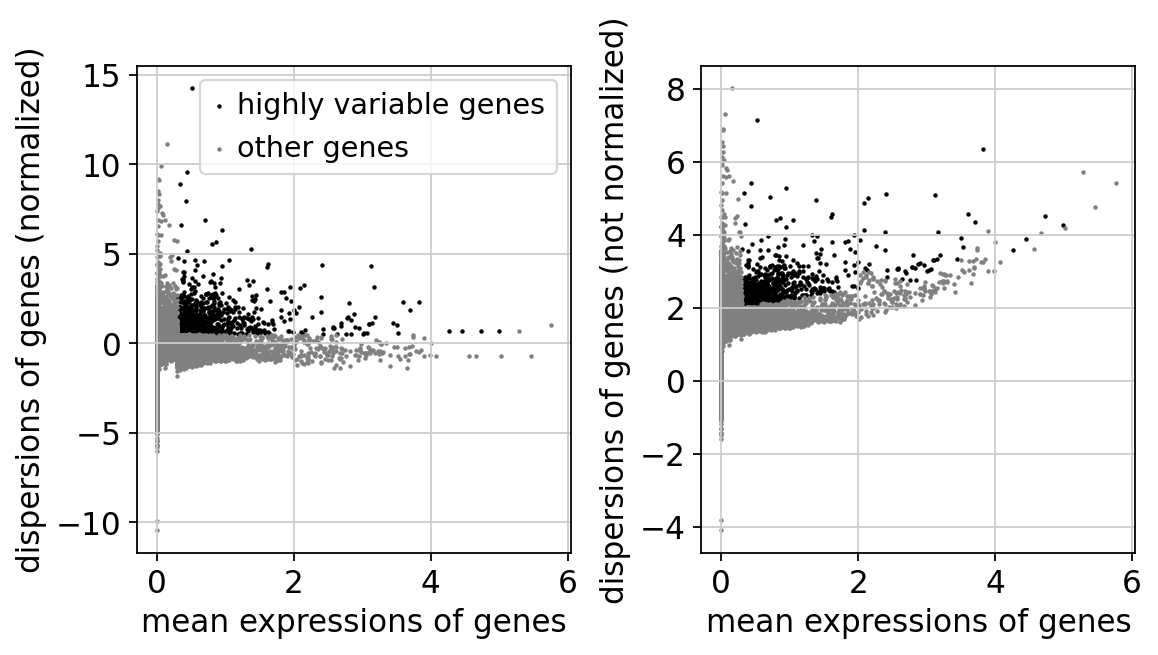

In [9]:
sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


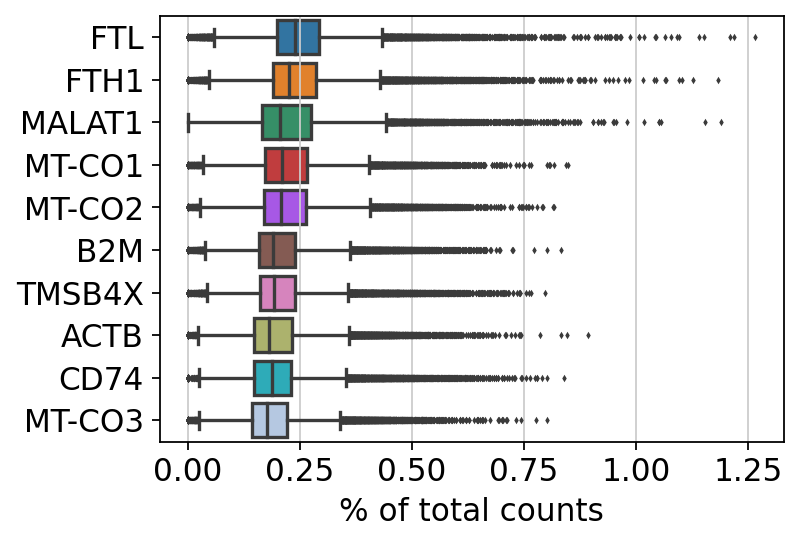

In [10]:
sc.pl.highest_expr_genes(adata, n_top=10, show=True)

In [11]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


In [12]:
sc.tl.umap(adata)

computing UMAP


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.57it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


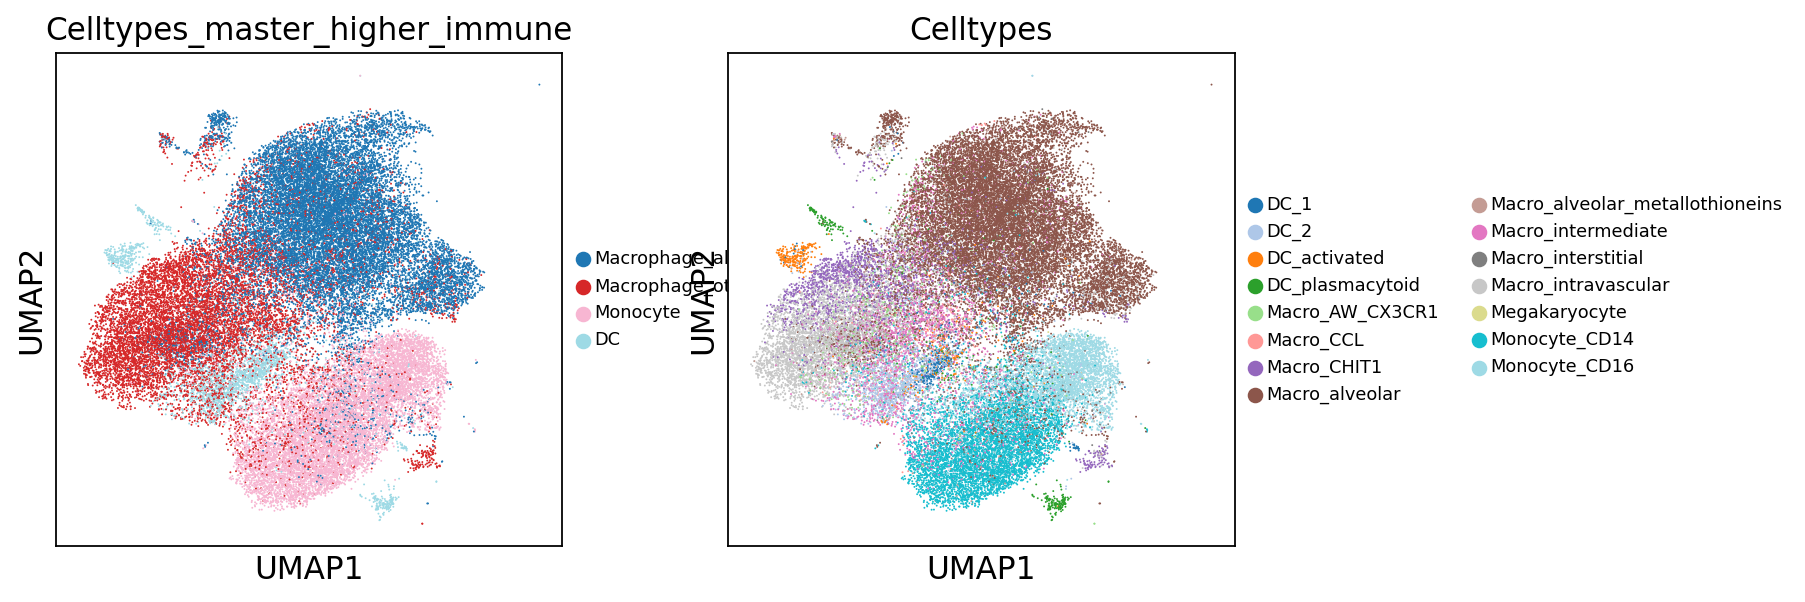

In [13]:
sc.pl.umap(adata, color=["Celltypes_master_higher_immune", "Celltypes"],#save= "Lymphoid.png",
           palette="tab20",legend_fontoutline=1, legend_fontsize=8)

<AxesSubplot:title={'center':'cell count'}>

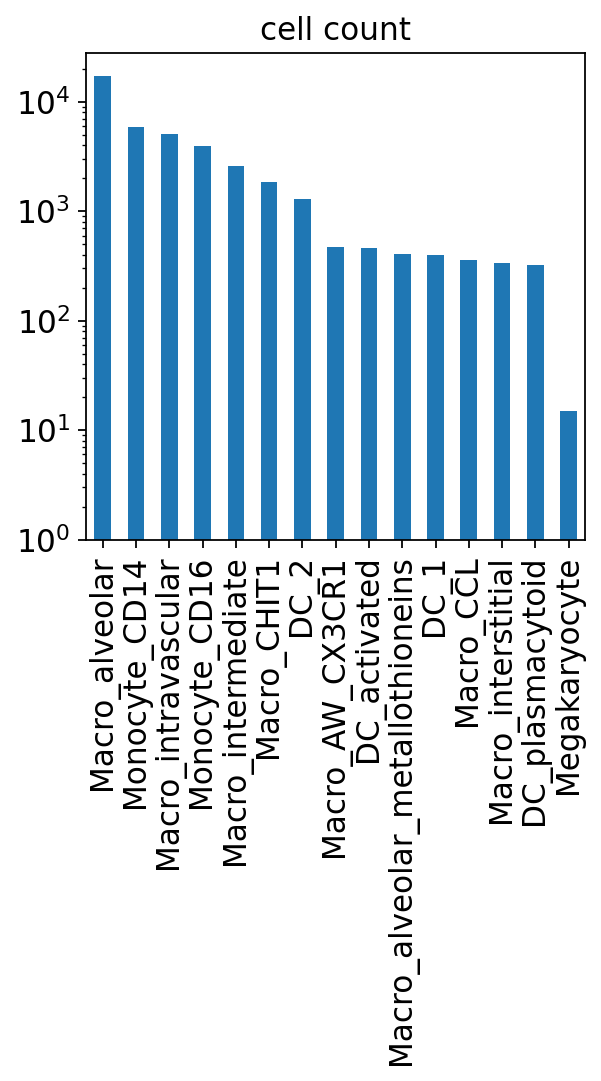

In [18]:
adata.obs['Celltypes'].value_counts().plot(kind='bar', log="y",
                                           grid=False, title='cell count')

ranking genes
    consider 'Celltypes' groups:
    with sizes: [  395  1301   459   322   468   358  1853 17098   410  2598   335  5033
    14  5932  3916]
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:41)


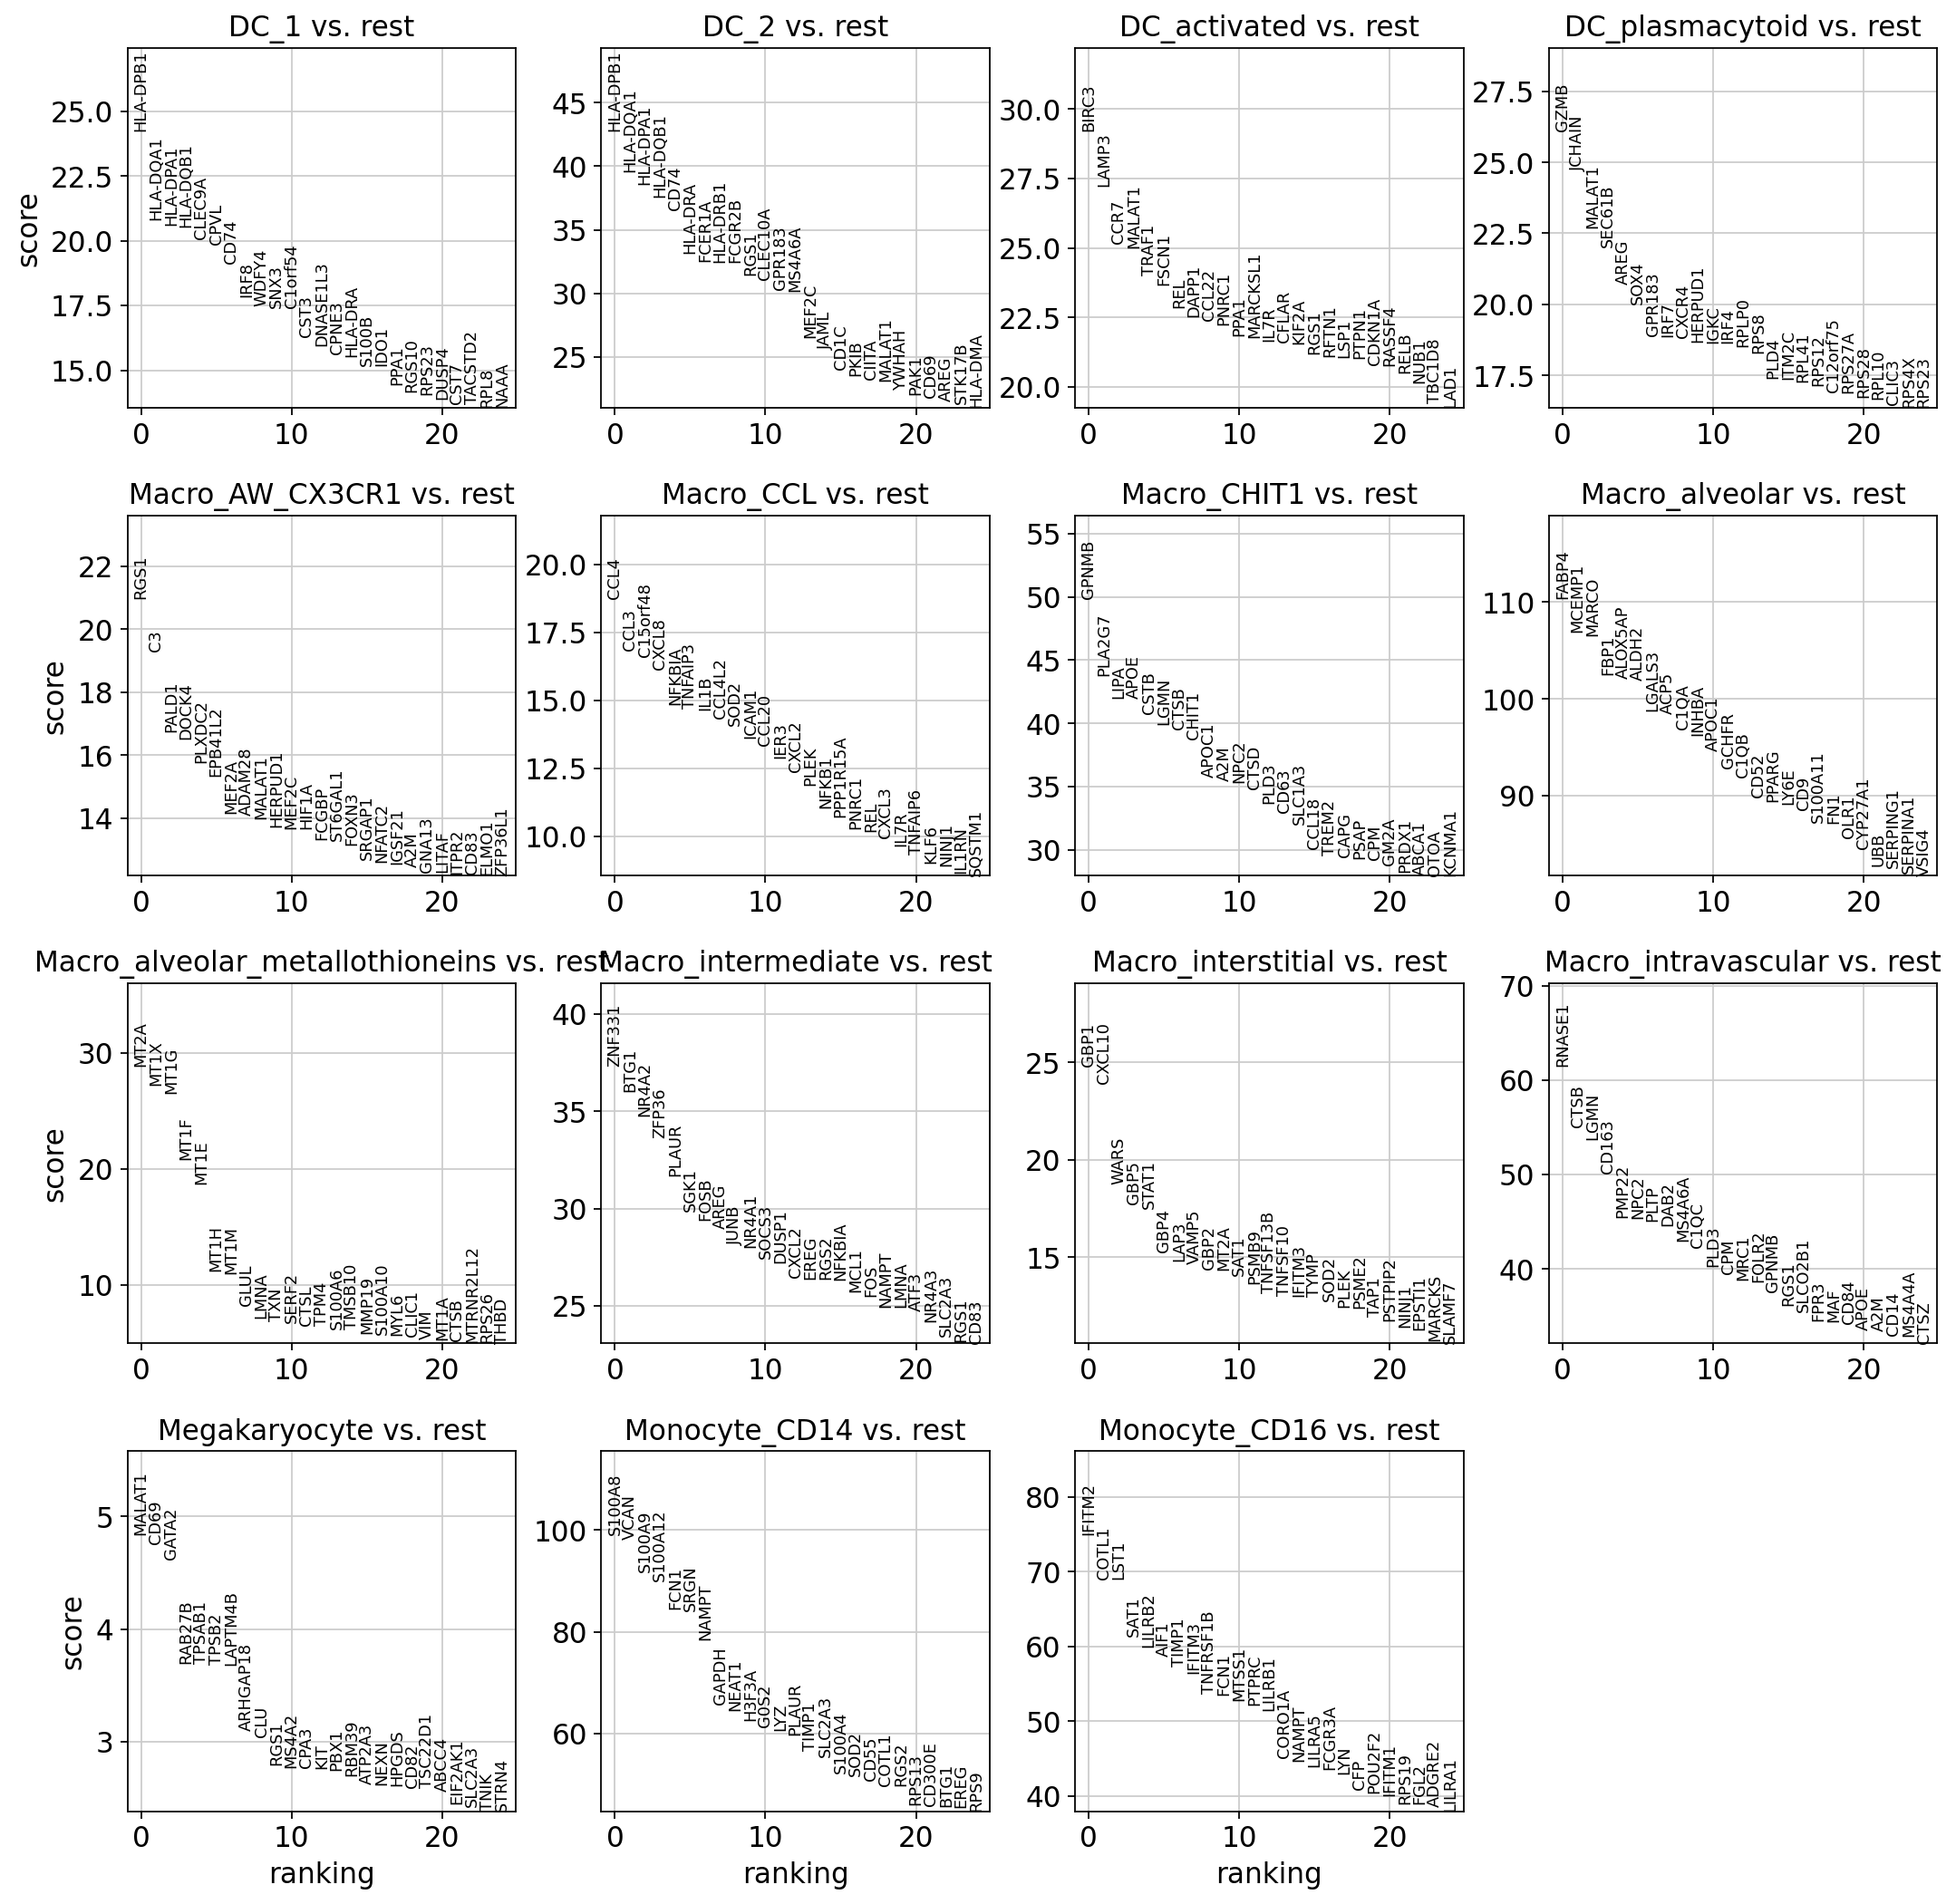

In [19]:
sc.tl.rank_genes_groups(adata, groupby= 'Celltypes', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata,  n_genes=25,  sharey=False, key= "wilcoxon")

In [20]:
adata.X.max()

8.449155

In [21]:
adata.write(tmpfile)

## Read prepocessed data

In [5]:
adata = sc.read_h5ad(tmpfile)

In [6]:
for clust in adata.obs.Celltypes.cat.categories: 
    c = clust
    c = c.replace("/", "_")
    f = "./DE_genelists_log2FC/Myeloid/" + c + ".csv"
    df = sc.get.rank_genes_groups_df(adata, group=clust,
                                    key='wilcoxon')
    df.to_csv(f, sep=",")

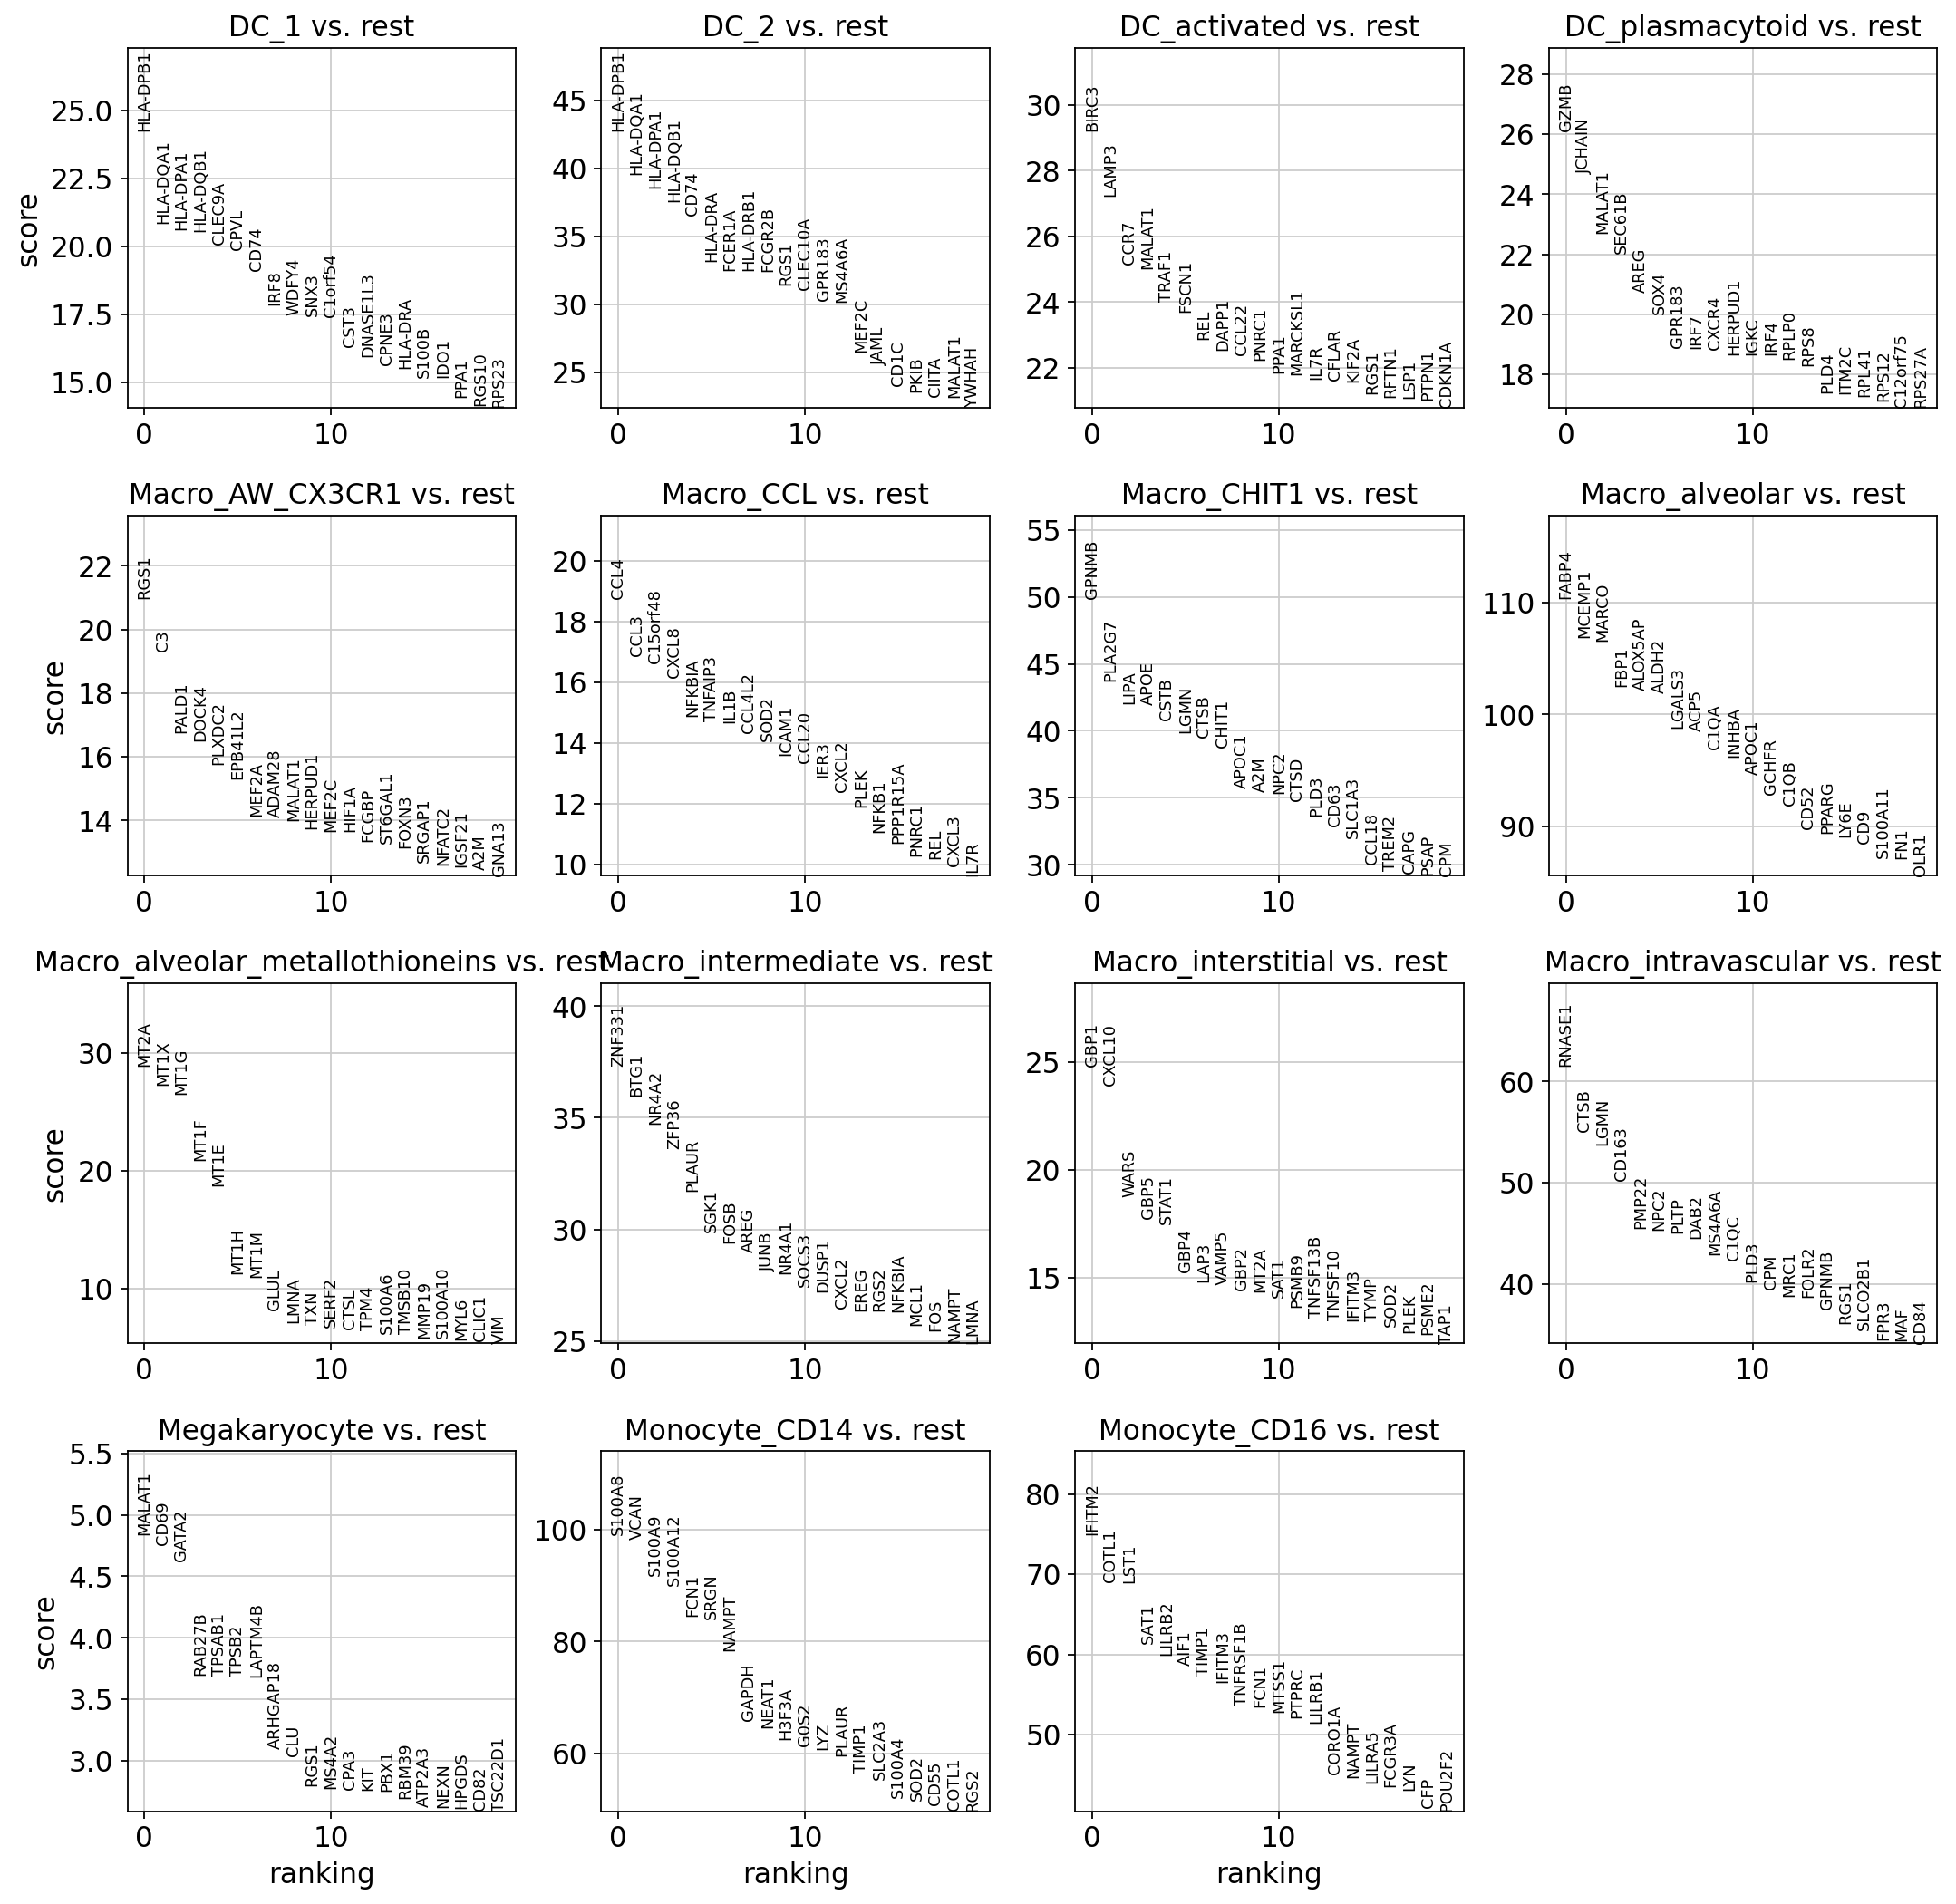

In [6]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key = "wilcoxon")

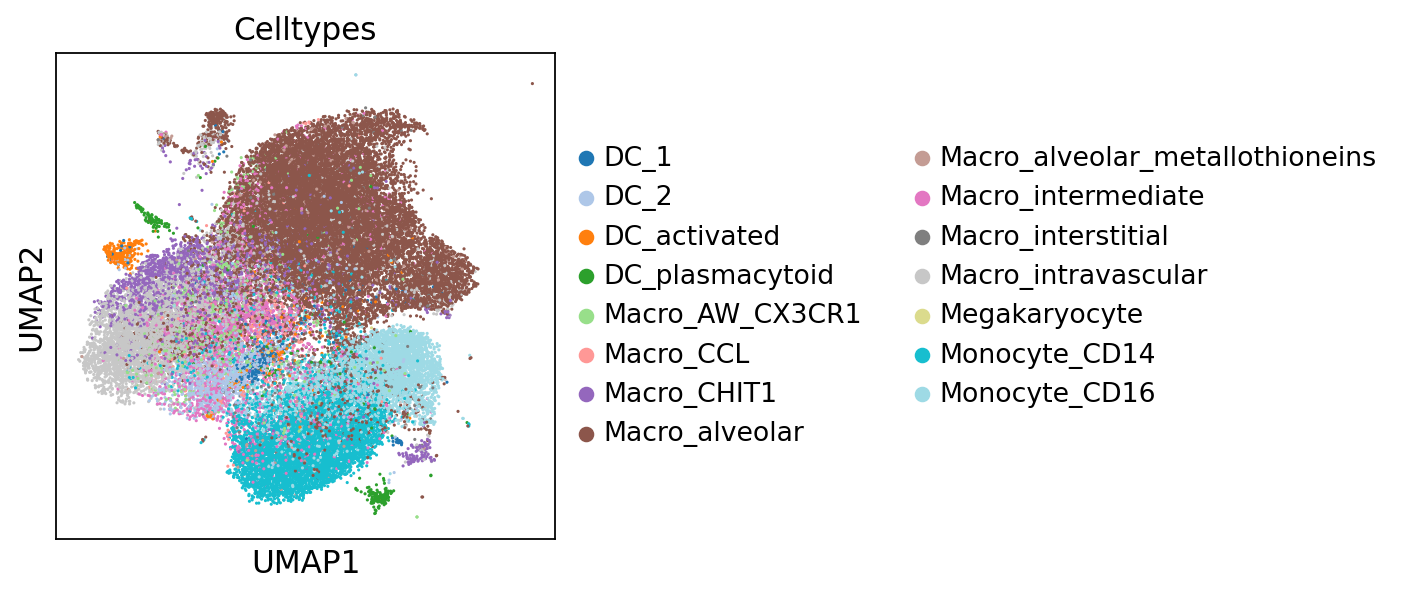

In [7]:
sc.pl.umap(adata, color="Celltypes",#save= "Lymphoid.png",
           legend_fontoutline=1, size=8, legend_fontsize=12)

## Loop to produce the lists of Tcell lineages

In [8]:
Subtypes = adata.obs['Celltypes'].unique()
Subtypes

['Monocyte_CD16', 'Macro_intravascular', 'Macro_alveolar', 'Monocyte_CD14', 'DC_plasmacytoid', ..., 'Macro_intermediate', 'Macro_AW_CX3CR1', 'Macro_CCL', 'Megakaryocyte', 'DC_activated']
Length: 15
Categories (15, object): ['DC_1', 'DC_2', 'DC_activated', 'DC_plasmacytoid', ..., 'Macro_intravascular', 'Megakaryocyte', 'Monocyte_CD14', 'Monocyte_CD16']

In [9]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])

0 Monocyte_CD16
1 Macro_intravascular
2 Macro_alveolar
3 Monocyte_CD14
4 DC_plasmacytoid
5 DC_2
6 DC_1
7 Macro_CHIT1
8 Macro_interstitial
9 Macro_alveolar_metallothioneins
10 Macro_intermediate
11 Macro_AW_CX3CR1
12 Macro_CCL
13 Megakaryocyte
14 DC_activated


### Marker genes for each Subtype

In [10]:
Markers = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    m = sc.get.rank_genes_groups_df(adata, group=Subtypes[i],
                                    key='wilcoxon', pval_cutoff=0.0001,
                                    log2fc_min=1)
    m = m.sort_values("logfoldchanges", ascending=False)
    m.reset_index(drop=True, inplace=True)
    Markers[i] = m

0 Monocyte_CD16
1 Macro_intravascular
2 Macro_alveolar
3 Monocyte_CD14
4 DC_plasmacytoid
5 DC_2
6 DC_1
7 Macro_CHIT1
8 Macro_interstitial
9 Macro_alveolar_metallothioneins
10 Macro_intermediate
11 Macro_AW_CX3CR1
12 Macro_CCL
13 Megakaryocyte
14 DC_activated


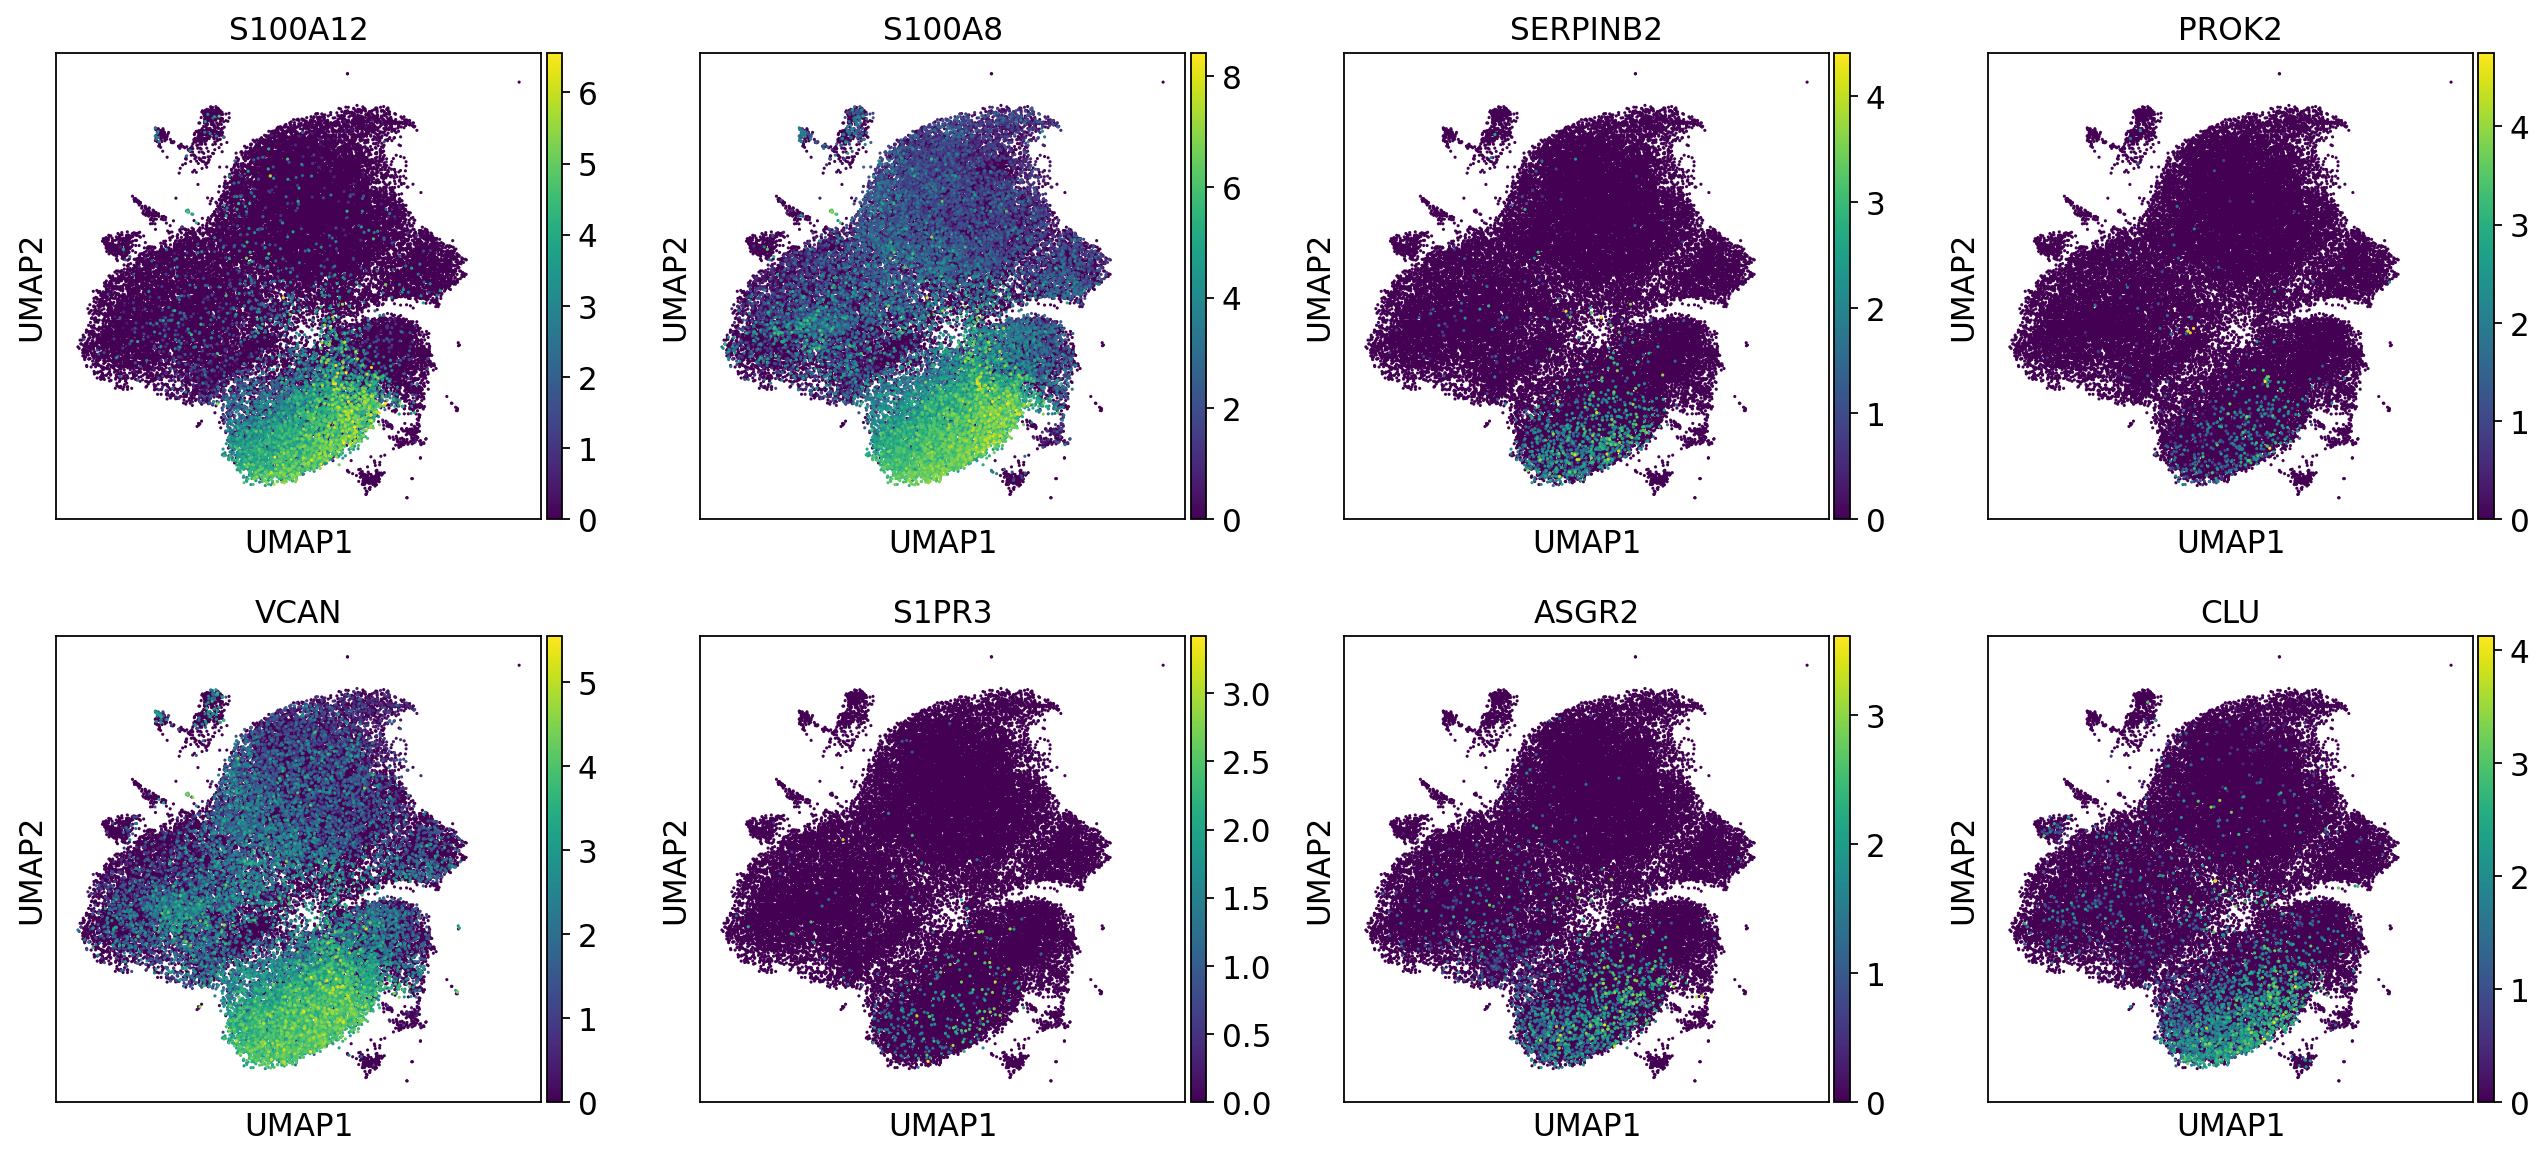

In [11]:
sc.pl.umap(adata, color= Markers[3]["names"][0:8], size=8 ) # top

0 Monocyte_CD16


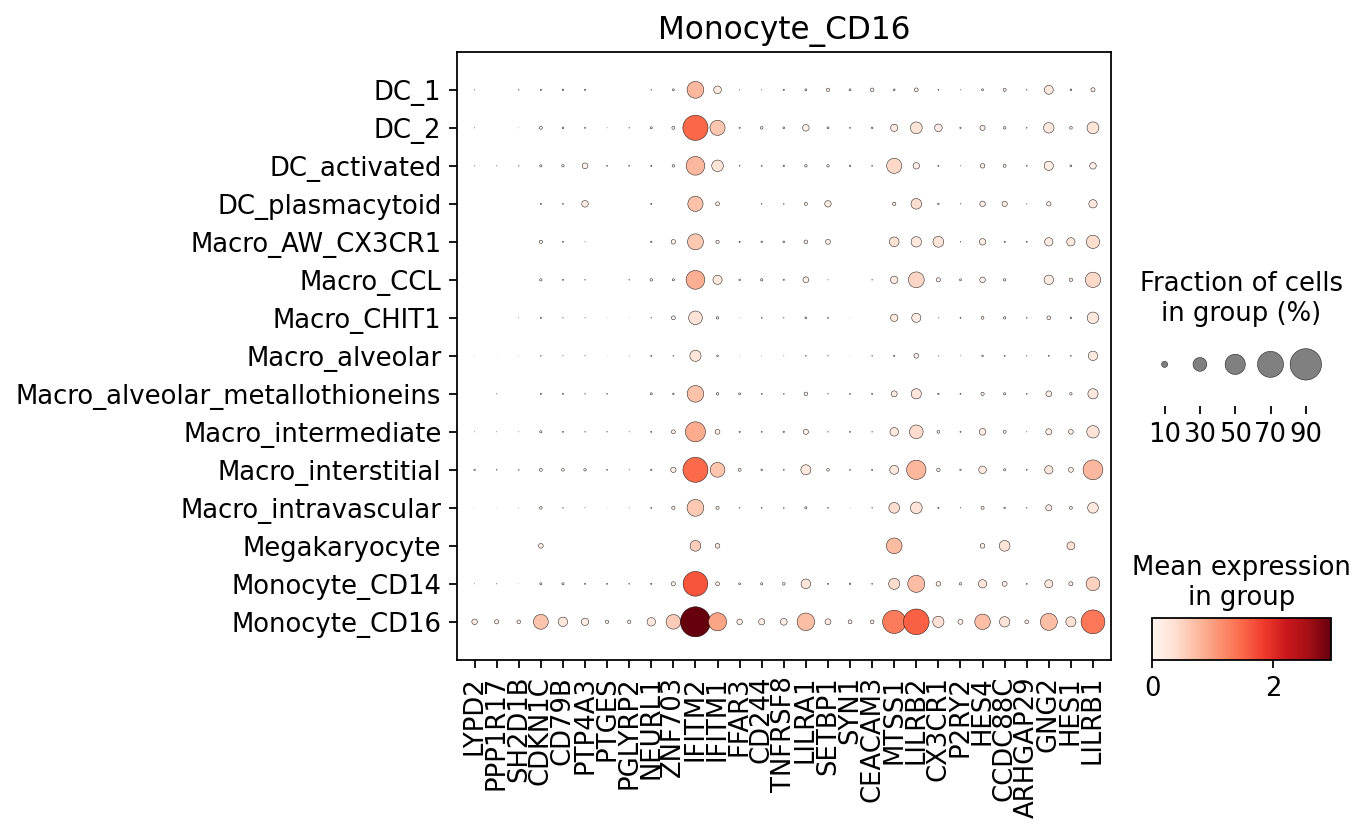

1 Macro_intravascular


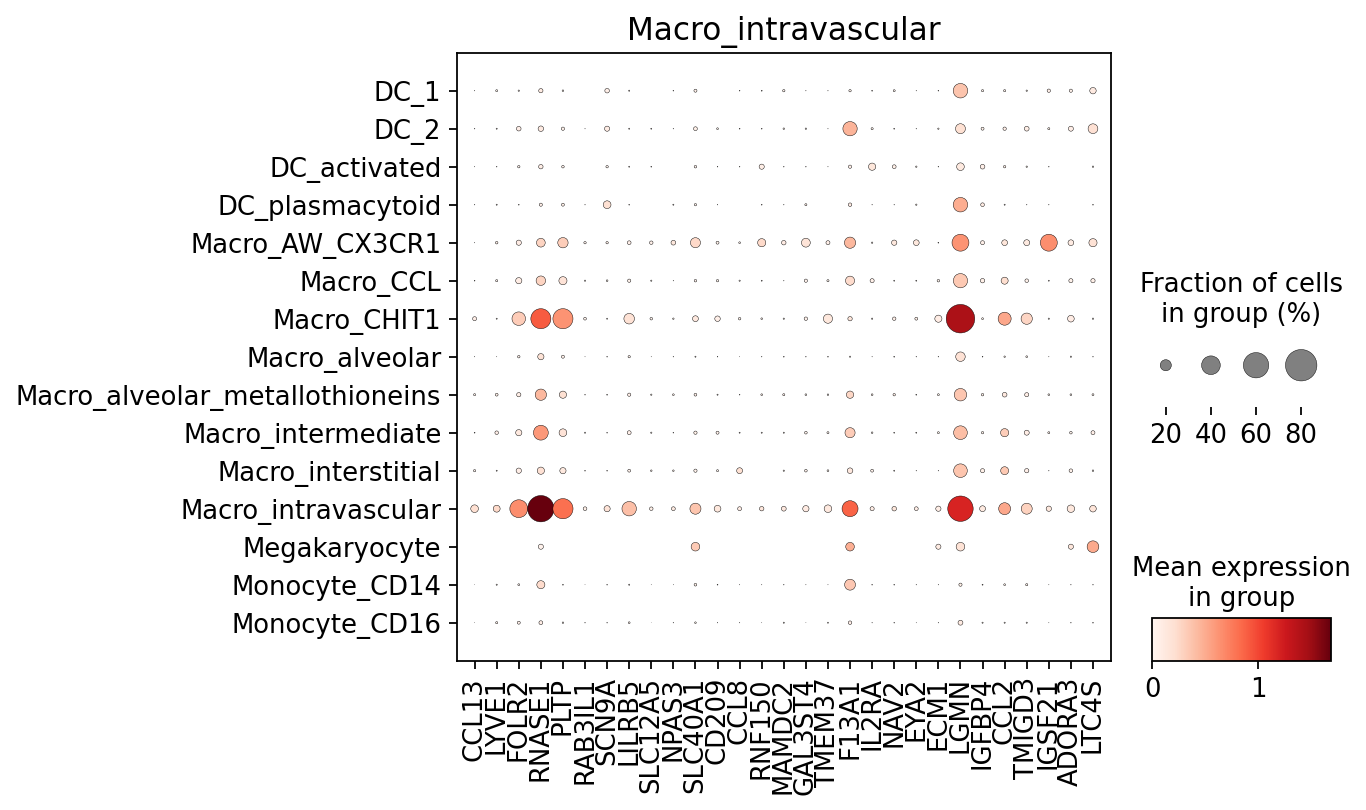

2 Macro_alveolar


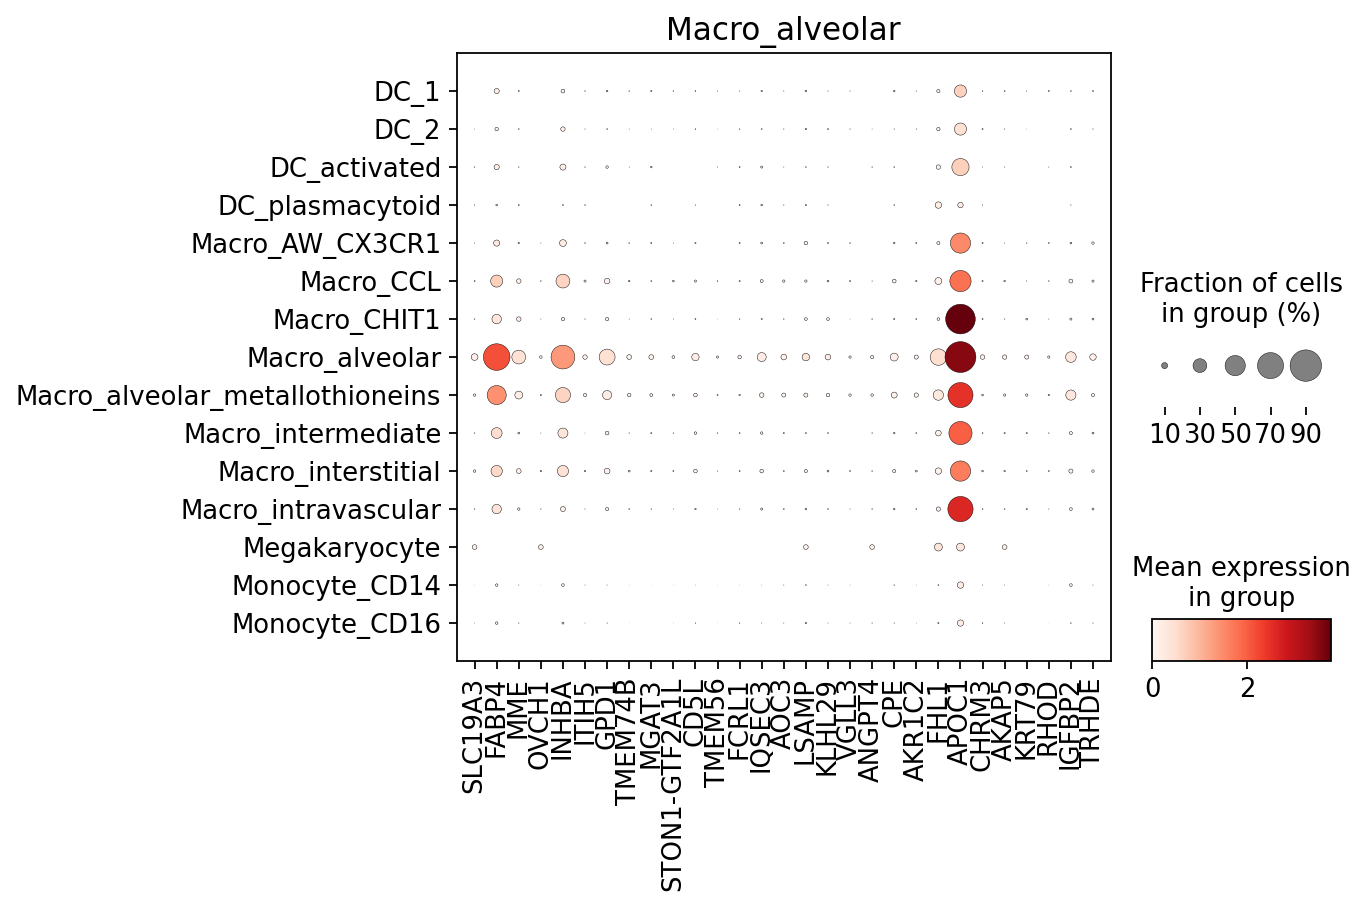

3 Monocyte_CD14


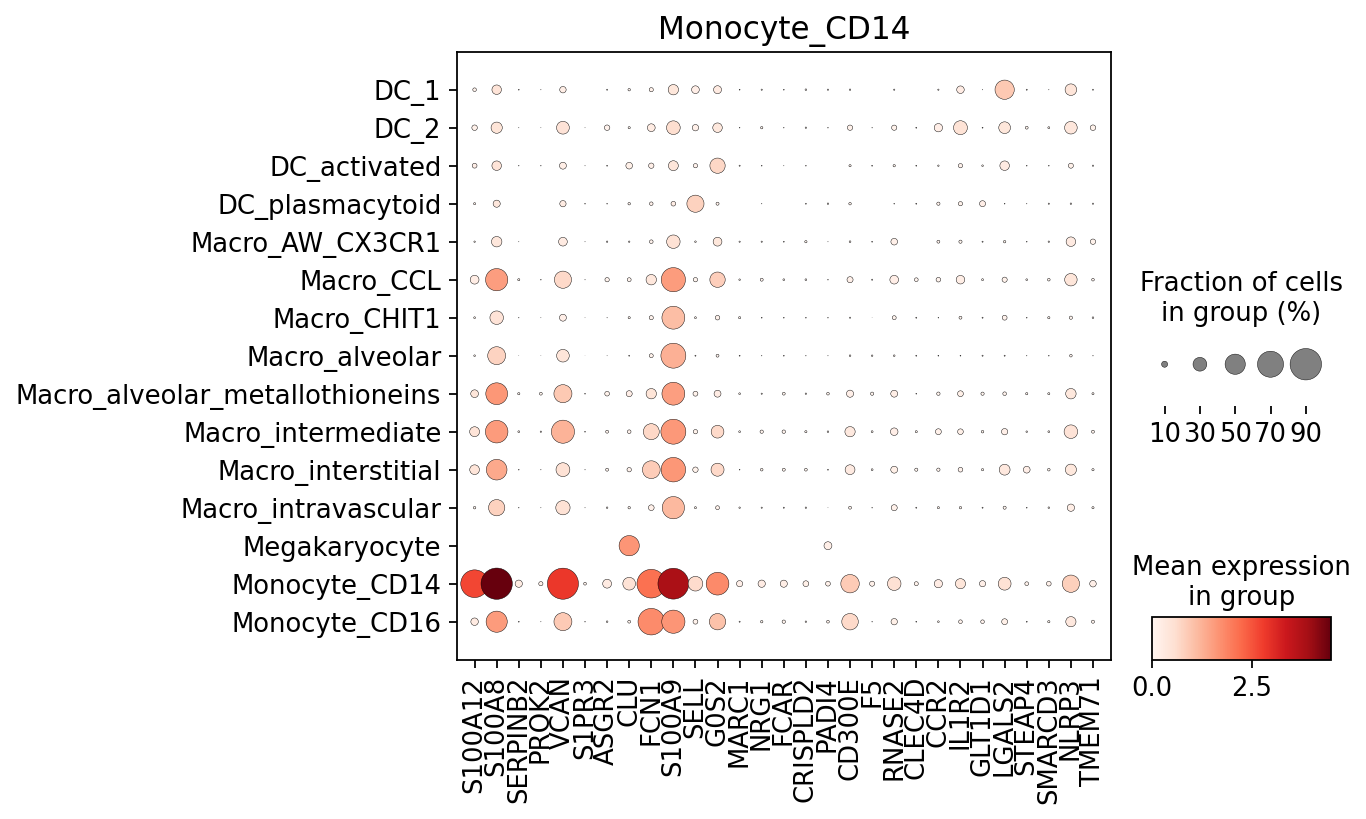

4 DC_plasmacytoid


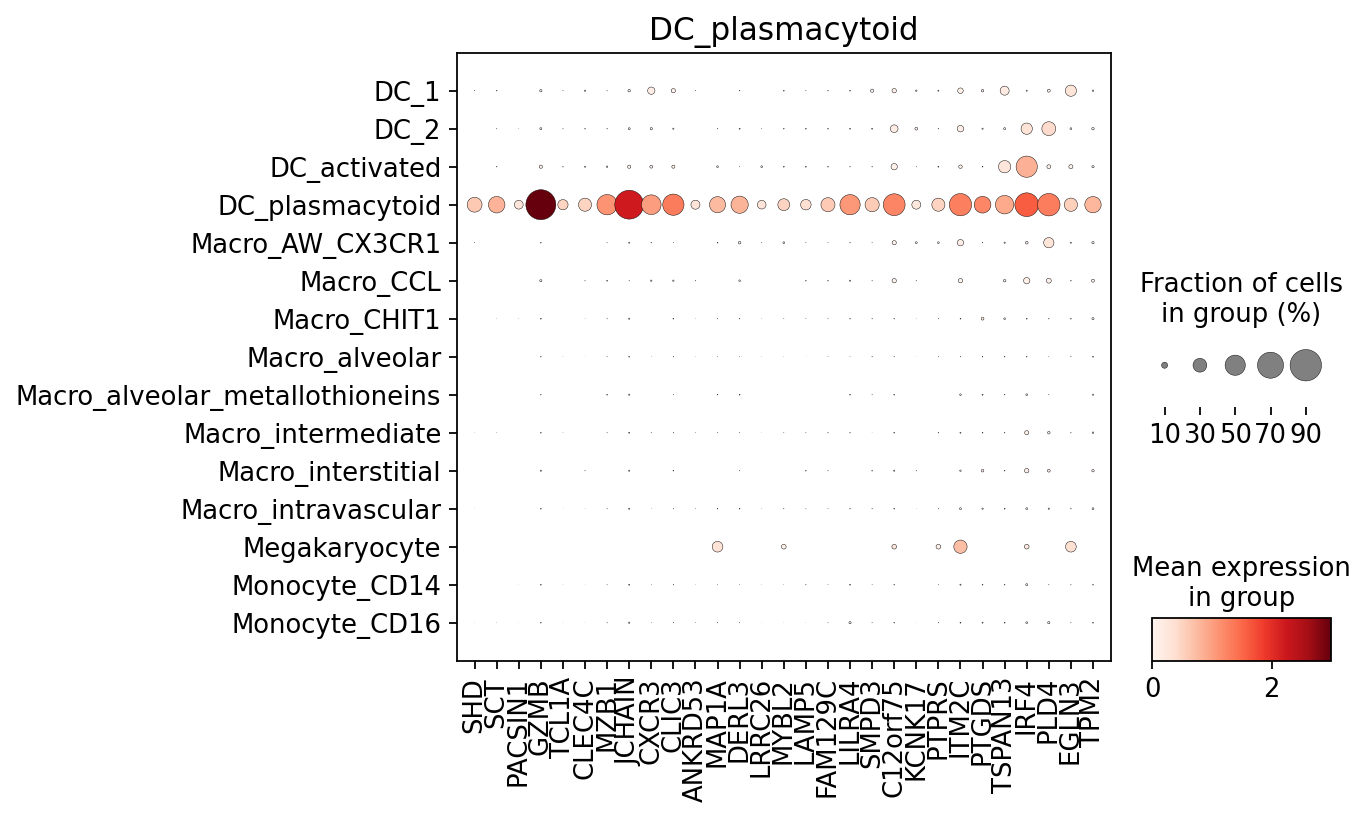

5 DC_2


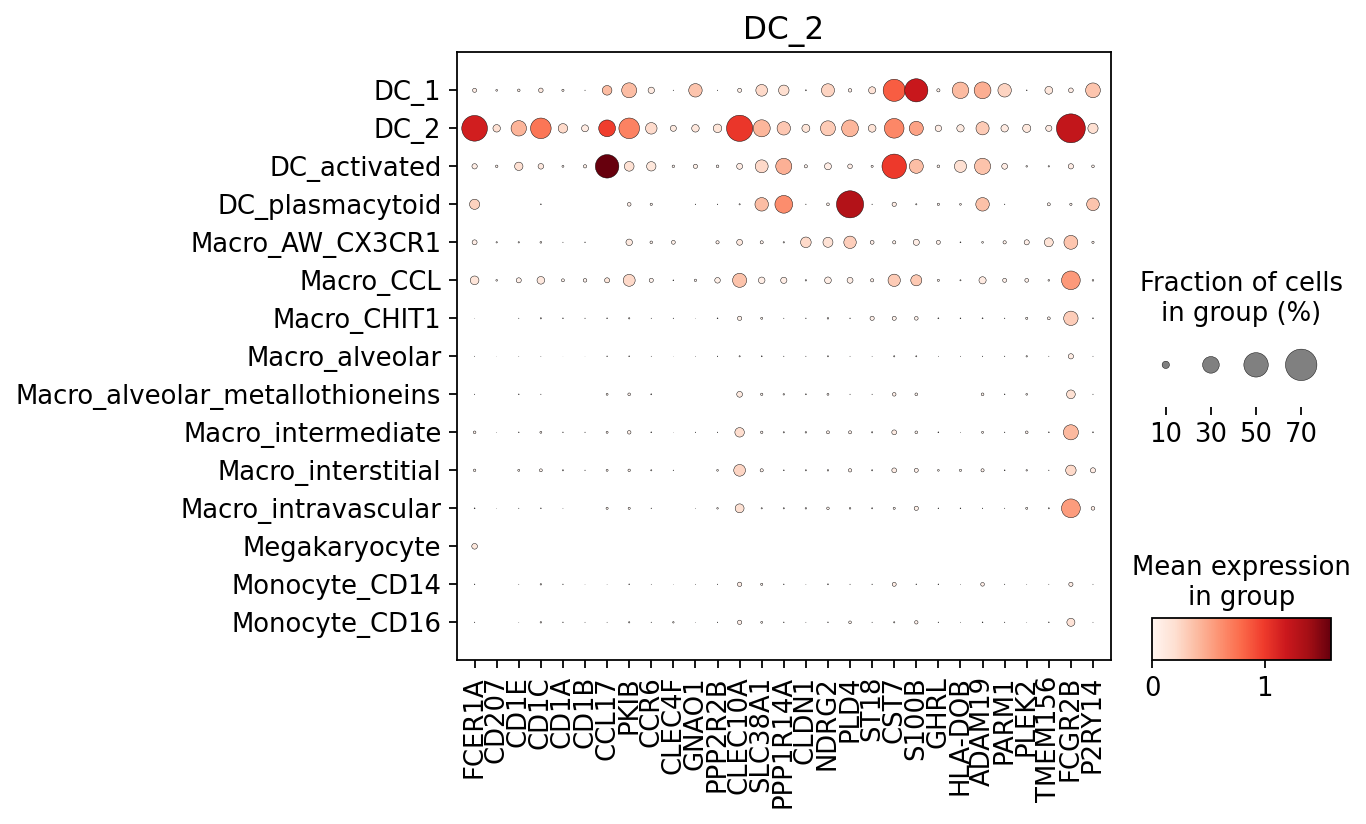

6 DC_1


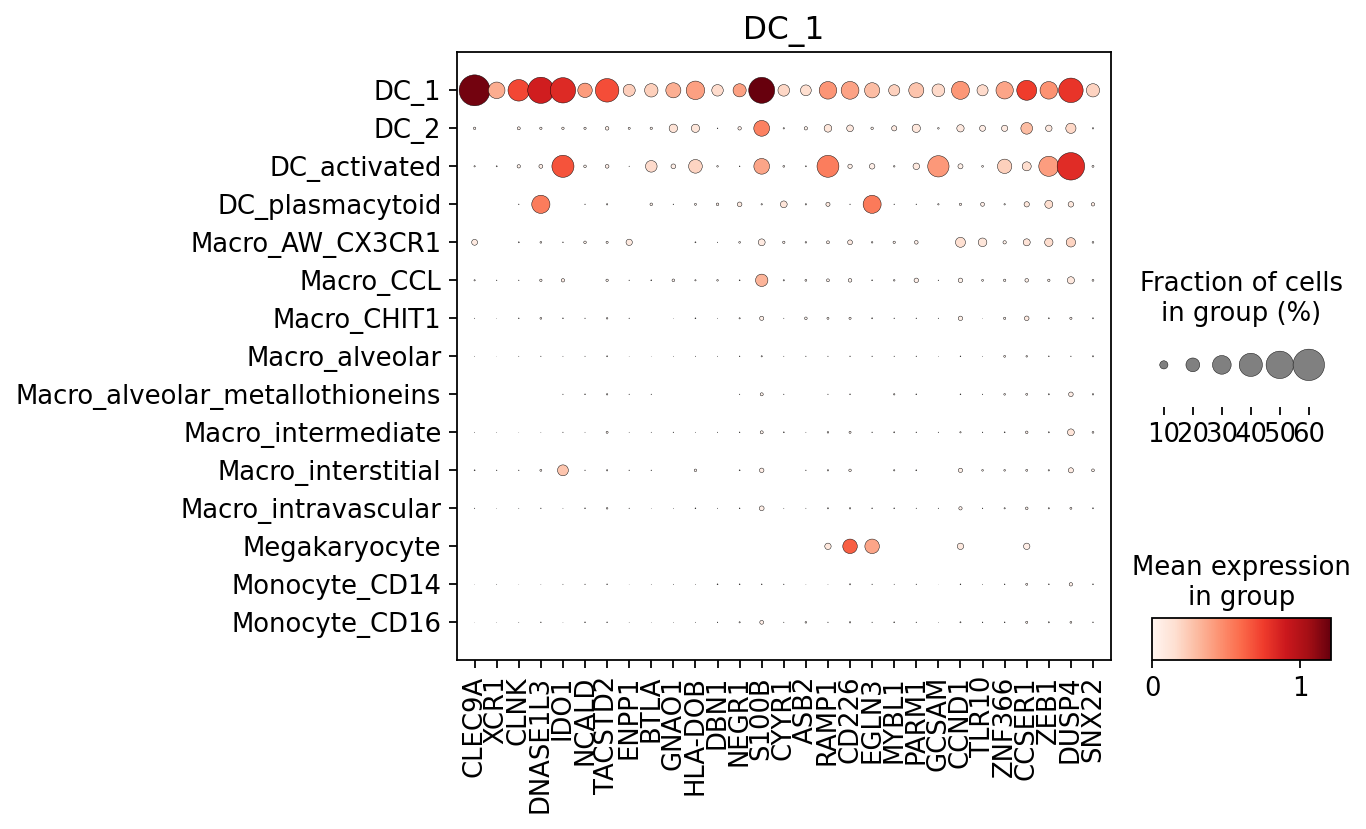

7 Macro_CHIT1


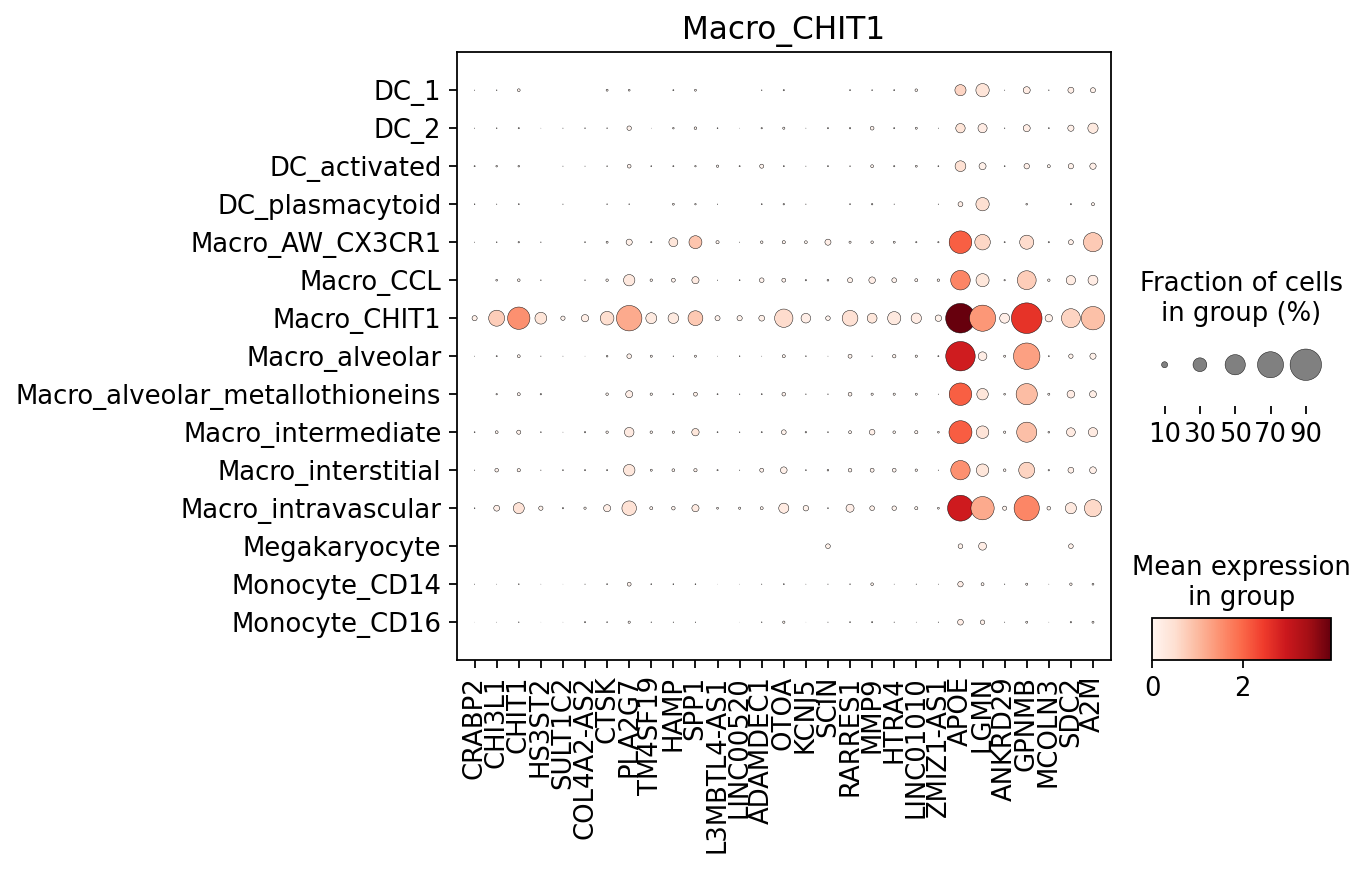

8 Macro_interstitial


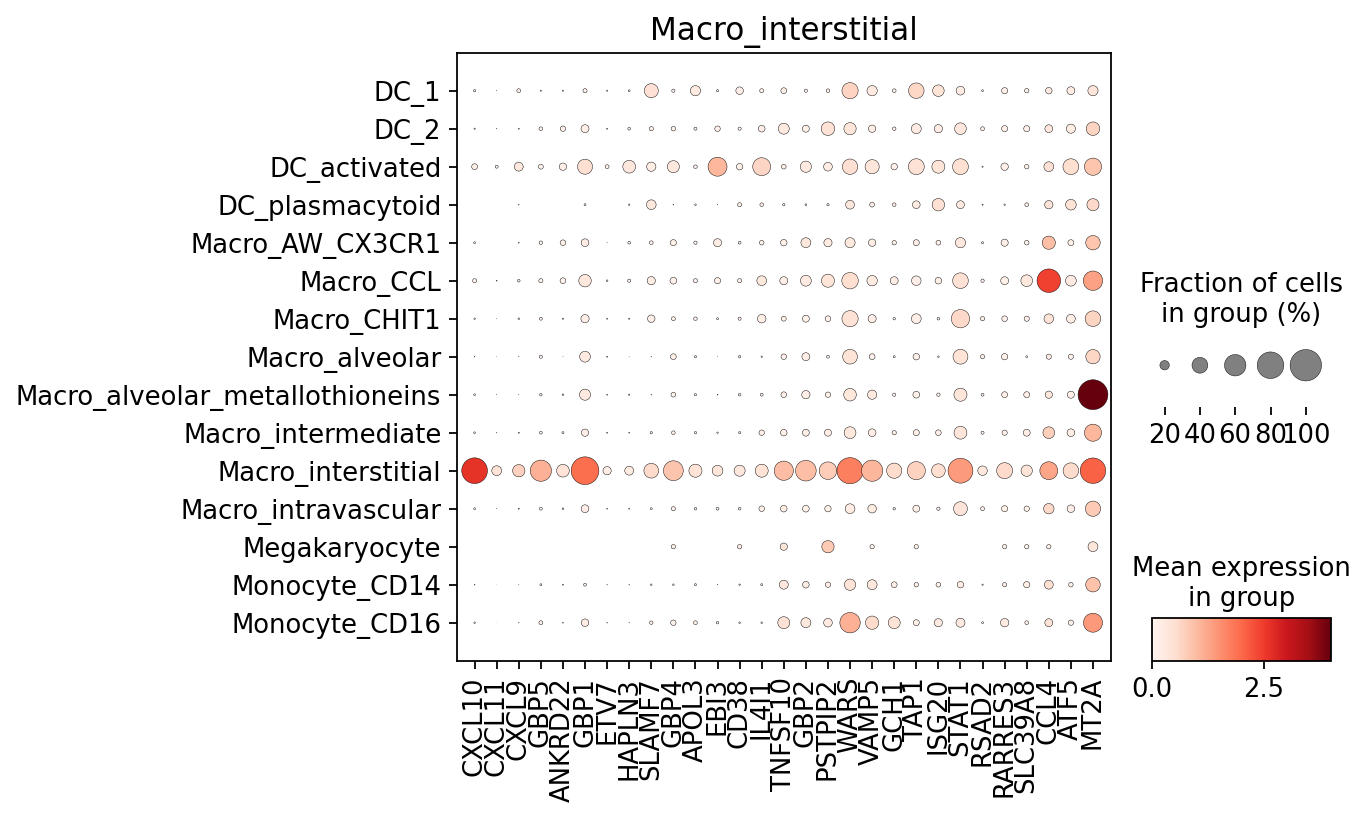

9 Macro_alveolar_metallothioneins


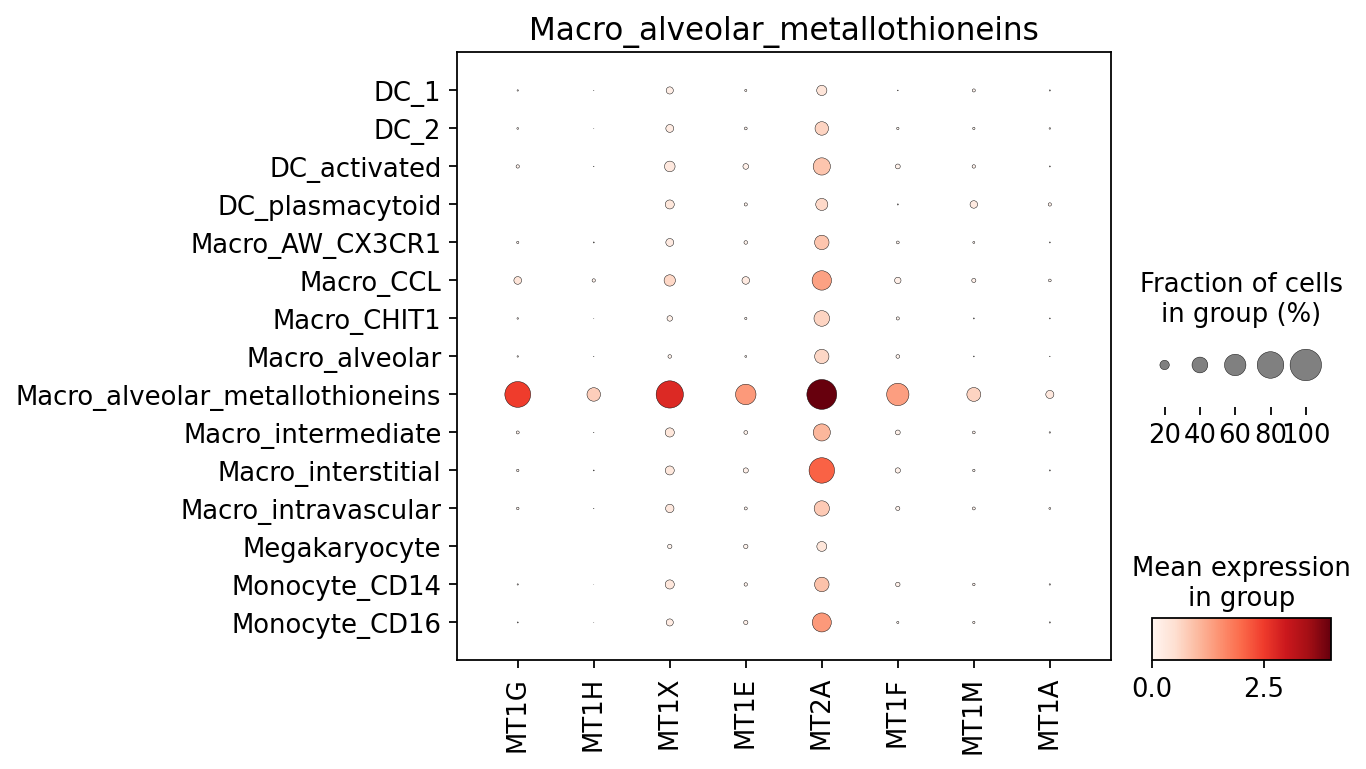

10 Macro_intermediate


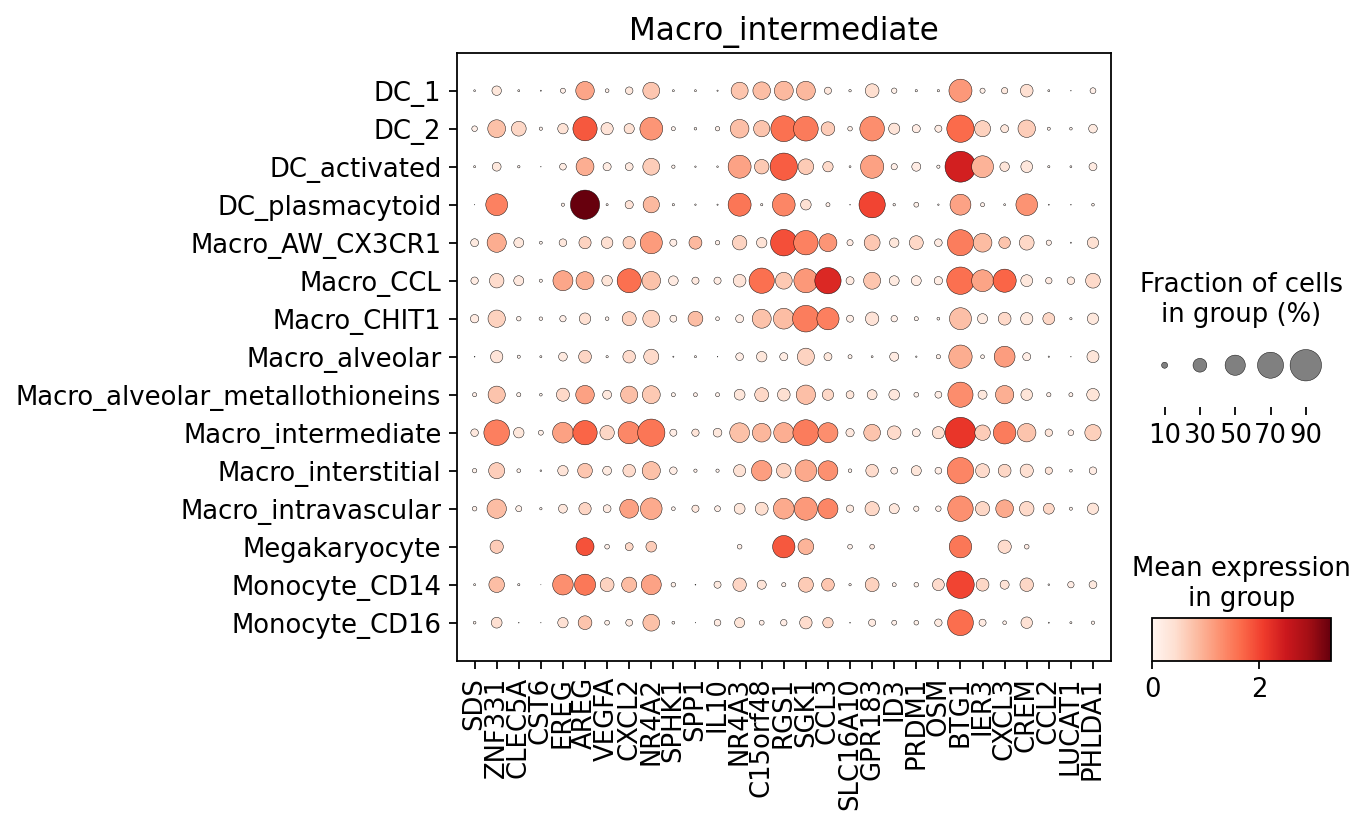

11 Macro_AW_CX3CR1


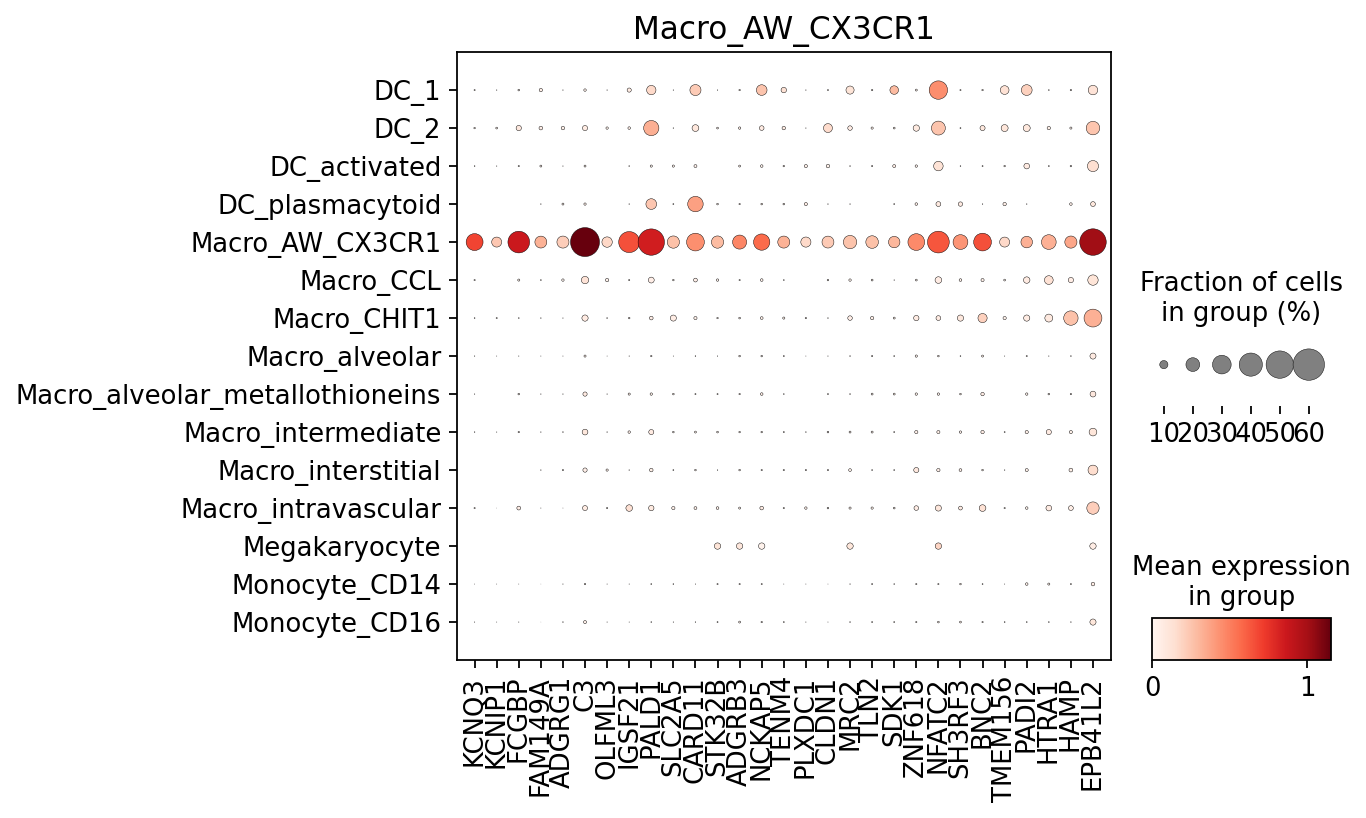

12 Macro_CCL


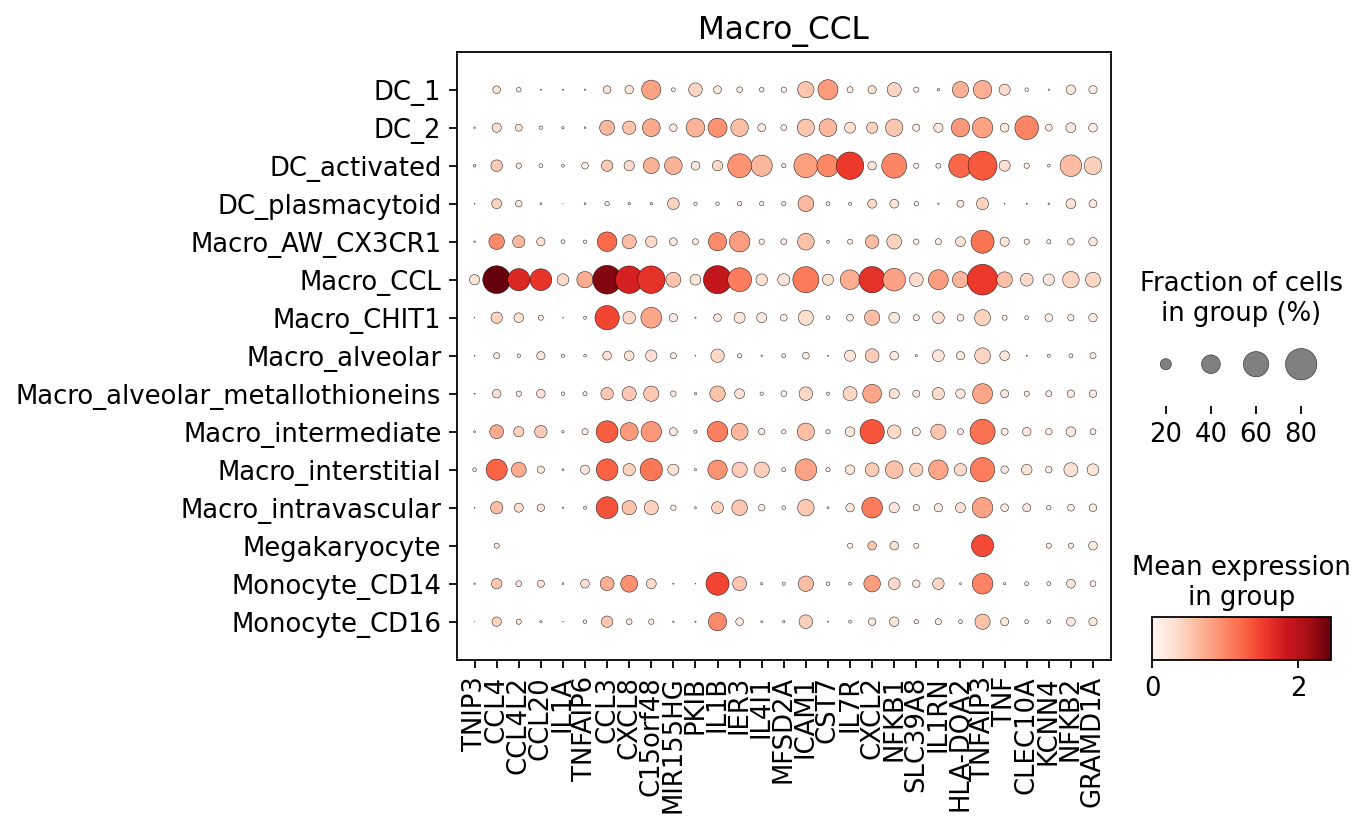

13 Megakaryocyte
14 DC_activated


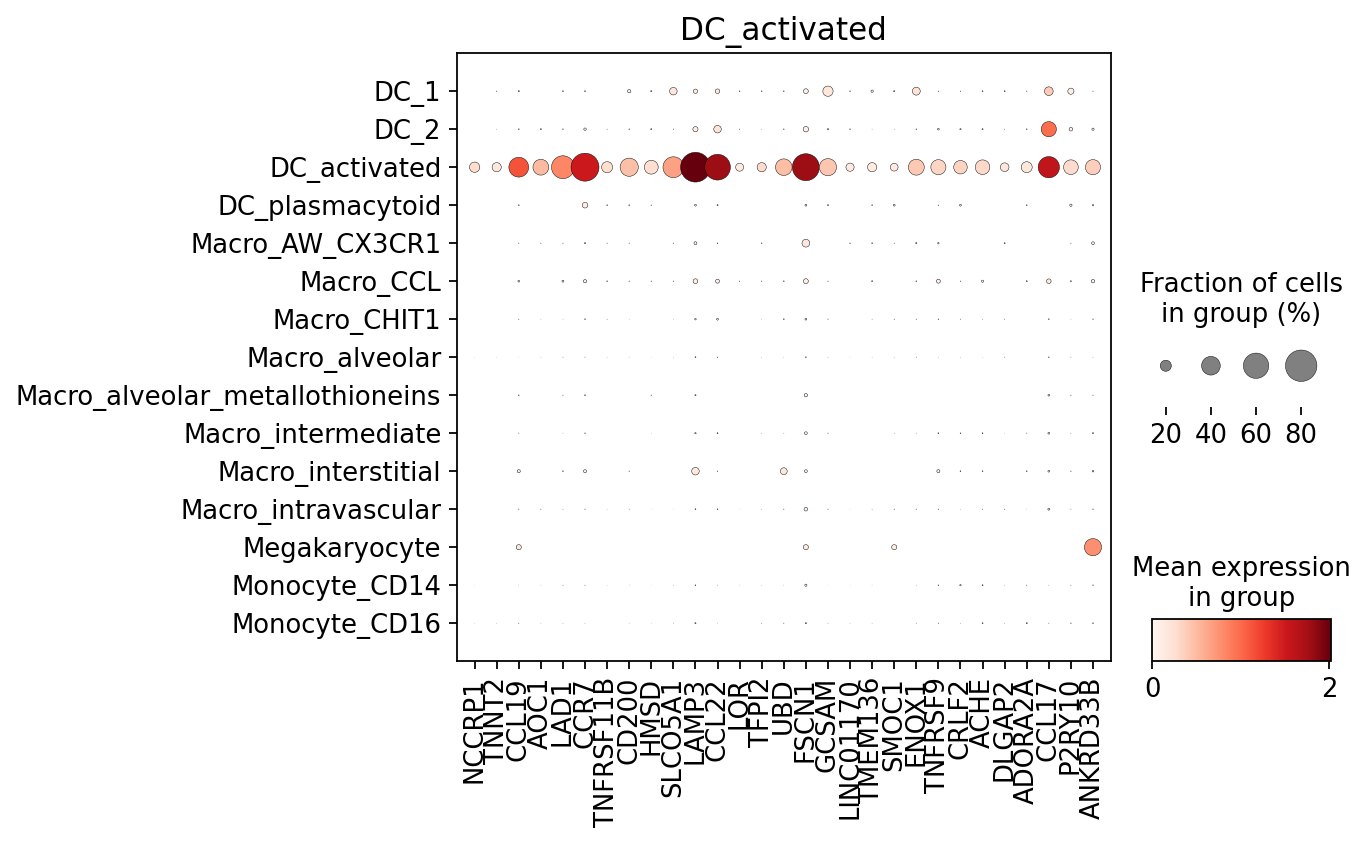

In [13]:
for i in range(0,len(Subtypes)):
    print(i, Subtypes[i])
    n = len(Markers[i]["names"])
    if n > 0 :
        if n > 30 :
            sc.pl.dotplot(adata, Markers[i]["names"][0:29], groupby='Celltypes', title= Subtypes[i], figsize= (7,5))
        else :
            sc.pl.dotplot(adata, Markers[i]["names"][0:n-1], groupby='Celltypes', title= Subtypes[i], figsize= (7,5))

### Get names of 500 top markers (if possible) for each Subtype

In [14]:
#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [15]:
Sets = [[]]*len(Subtypes)
CompleteSets = [[]]*len(Subtypes)

for i in range(0,len(Subtypes)):
    CompleteSets[i] = Markers[i]['names']
    n = len(Markers[i])
    print(i, Subtypes[i], n)
    if n > 500 :
        print("yes")
        Sets[i] = Markers[i].loc[0:499,'names']
    else :
        print("no")
        Sets[i] = Markers[i].loc[0:n-1,'names']

0 Monocyte_CD16 350
no
1 Macro_intravascular 261
no
2 Macro_alveolar 645
yes
3 Monocyte_CD14 294
no
4 DC_plasmacytoid 241
no
5 DC_2 406
no
6 DC_1 241
no
7 Macro_CHIT1 409
no
8 Macro_interstitial 122
no
9 Macro_alveolar_metallothioneins 9
no
10 Macro_intermediate 98
no
11 Macro_AW_CX3CR1 578
yes
12 Macro_CCL 74
no
13 Megakaryocyte 0
no
14 DC_activated 630
yes


In [16]:
Dict_markers =  {}
CompleteDict_markers =  {}

for i in range(0,len(Subtypes)):
    Dict_markers[Subtypes[i]] = Sets[i]
    CompleteDict_markers[Subtypes[i]] = CompleteSets[i]

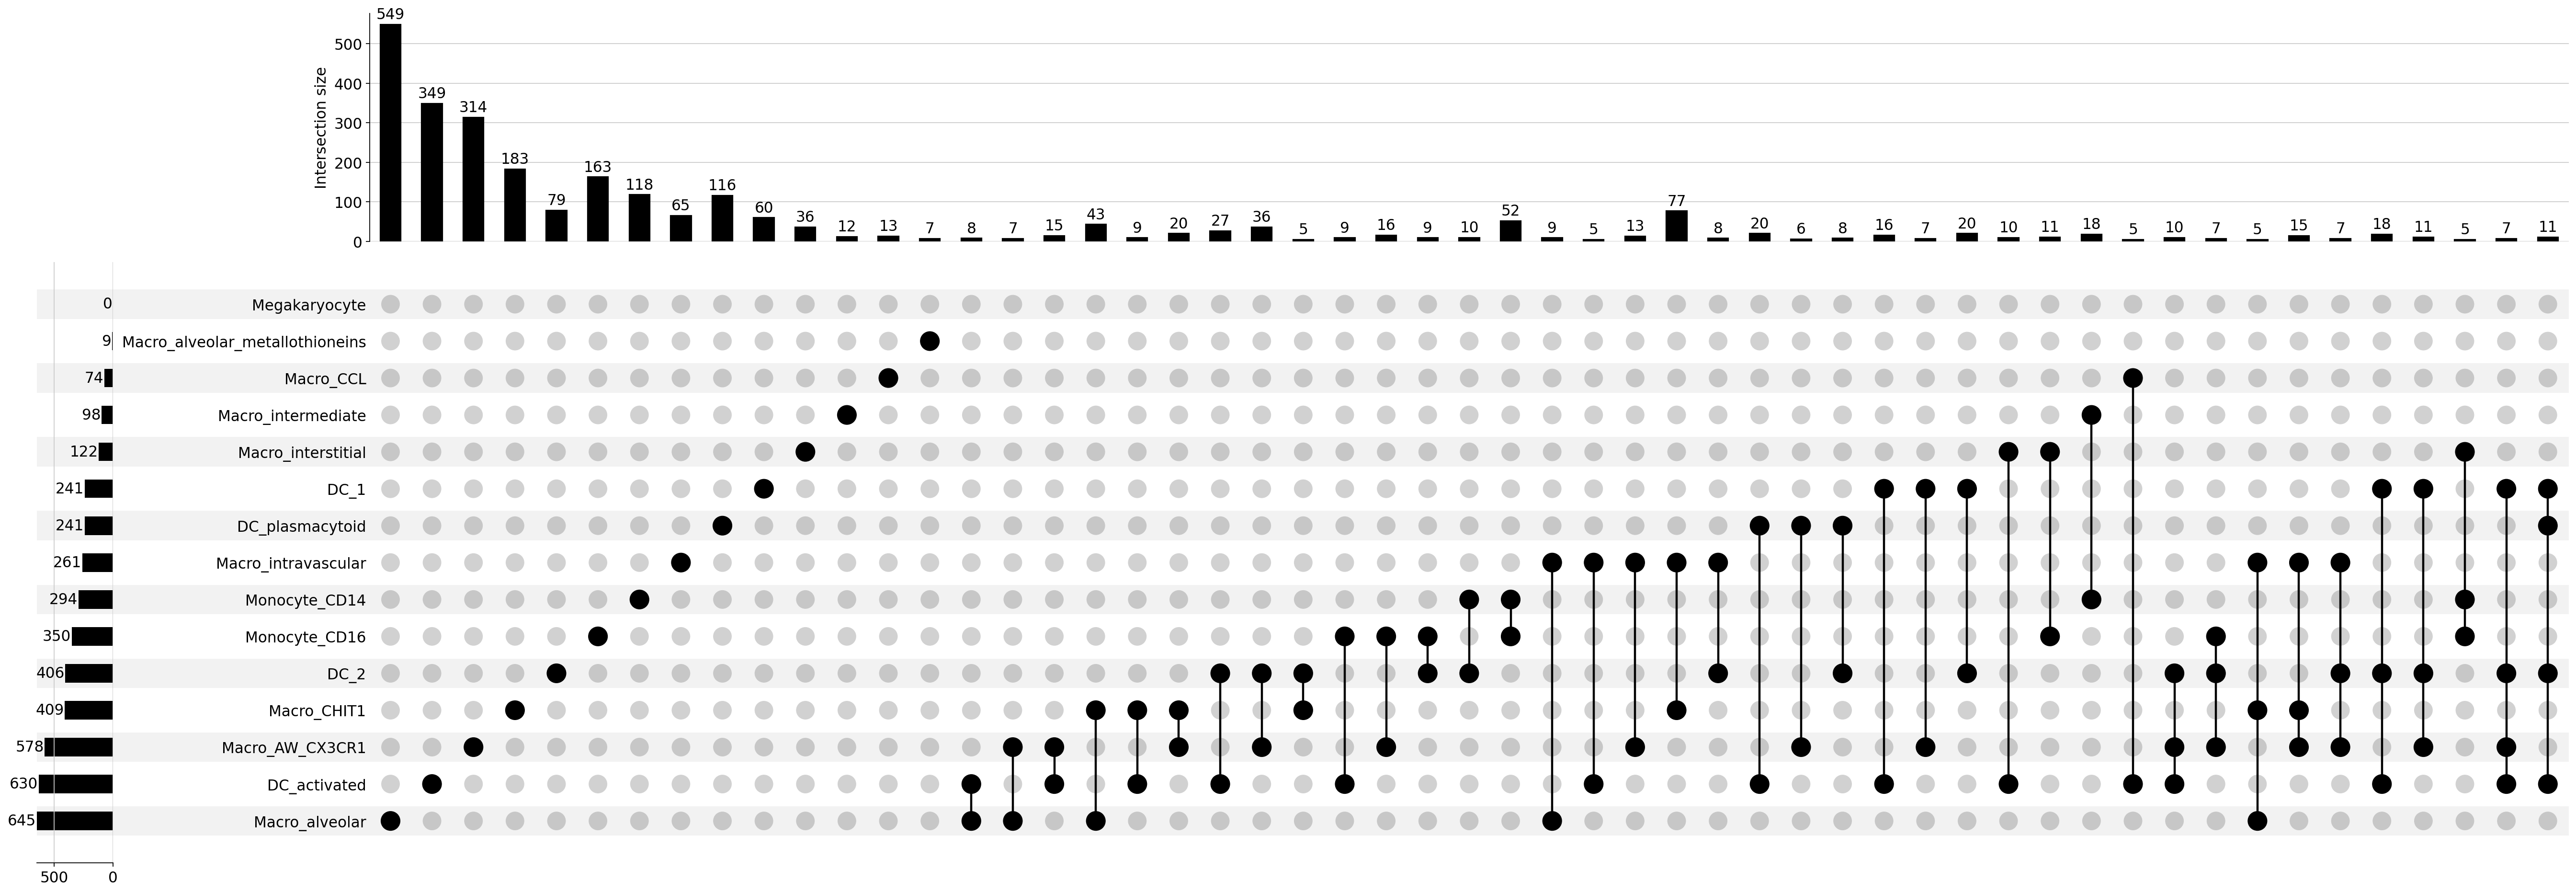

In [17]:
CT_markers = from_contents(CompleteDict_markers)

plt = UpSet(CT_markers, min_subset_size=5, subset_size='count',element_size=50,  show_counts=True).plot()

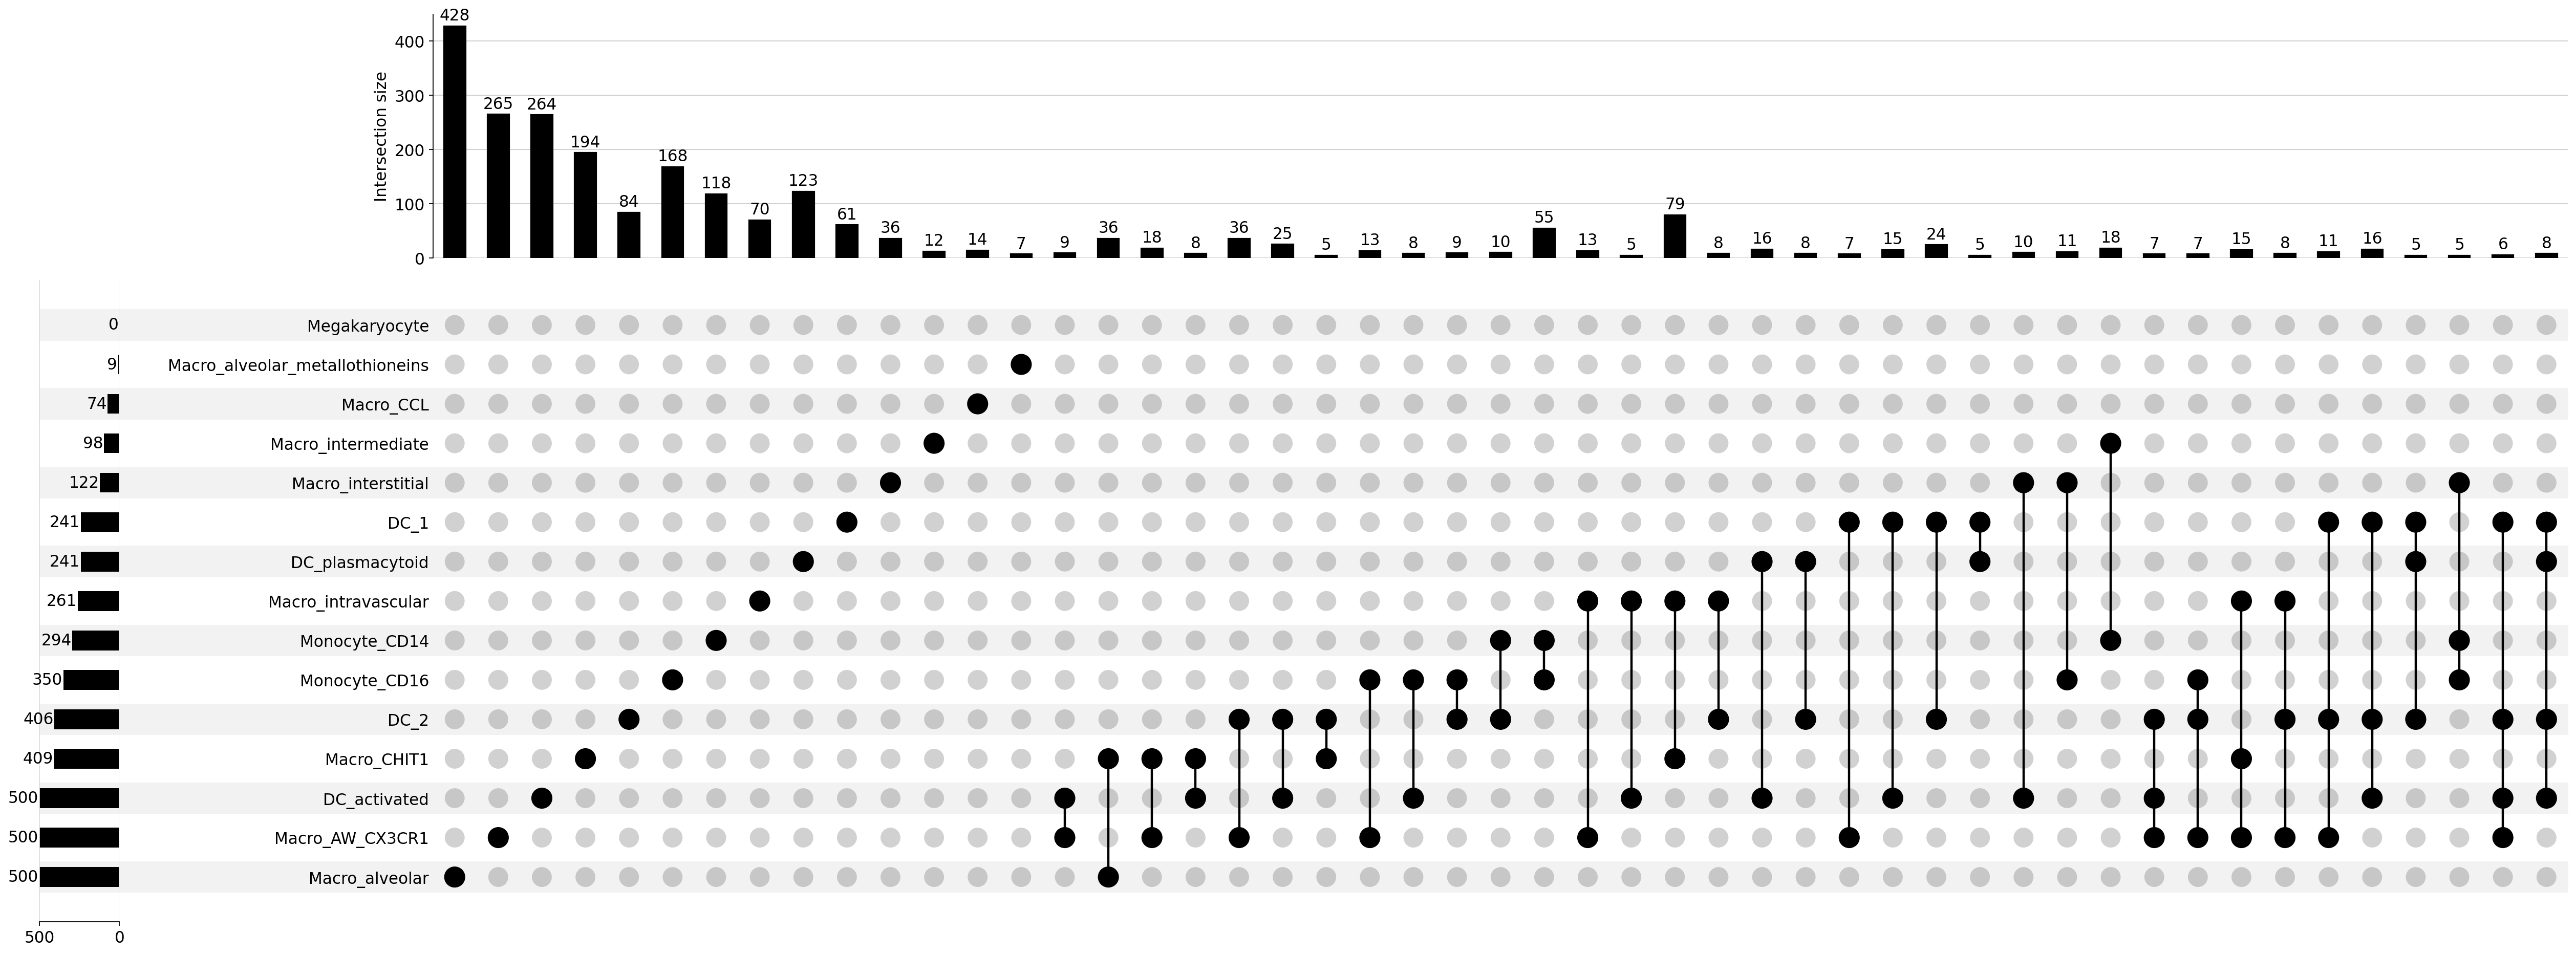

In [18]:
CT_500_markers = from_contents(Dict_markers)
plt = UpSet(CT_500_markers, min_subset_size=5, subset_size='count',sort_by="degree",
            element_size=50,  show_counts=True).plot()

In [19]:
Dict_markers['DC_1'].loc[0:9]

0      CLEC9A
1        XCR1
2        CLNK
3    DNASE1L3
4        IDO1
5       NCALD
6     TACSTD2
7       ENPP1
8        BTLA
9       GNAO1
Name: names, dtype: object

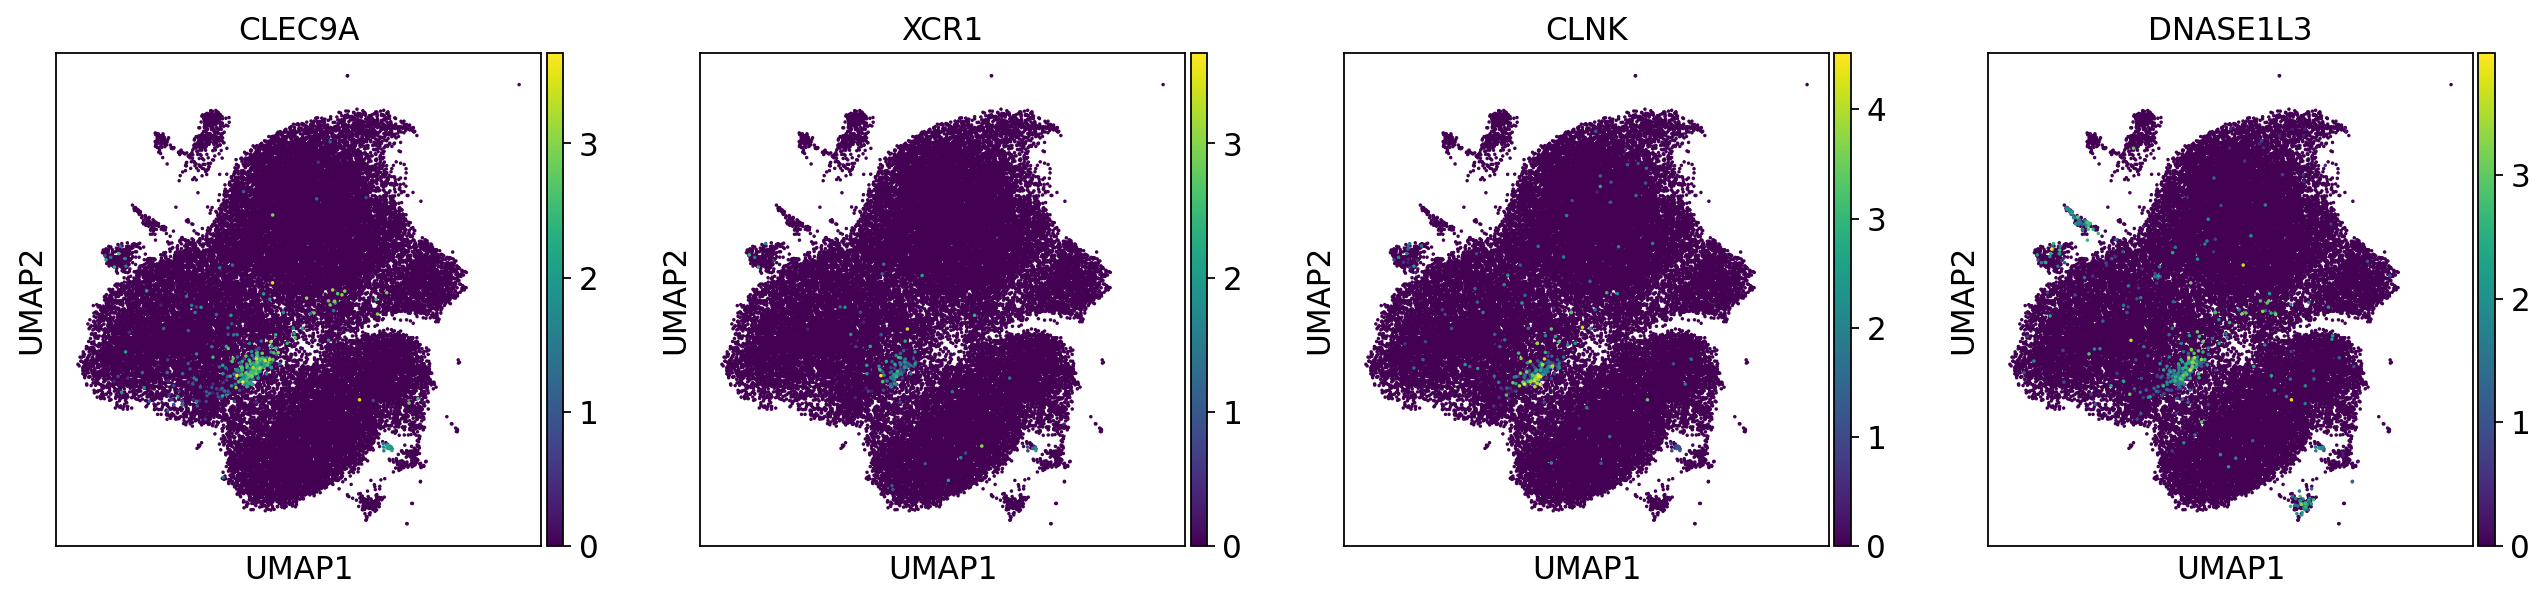

In [20]:
sc.pl.umap(adata, color=Dict_markers['DC_1'].loc[0:3], size=10) # top

## Write markers to csv

In [21]:
full_csv_path = '/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Myeloid/full.csv'

(pd.DataFrame.from_dict(data=CompleteDict_markers, orient='index')
   .to_csv(full_csv_path, header=False))

### Convert gene IDs to Ensemble IDs

In [22]:
%load_ext rpy2.ipython

In [23]:
%%R -i full_csv_path -w 5 -h 5 --units in -r 200
# import full_csv_path from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution
library("EnsDb.Hsapiens.v86")

print(full_csv_path)

R[write to console]: Loading required package: ensembldb

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: S4Vectors

R[write to console]: 
Attaching package: ‘S4Vectors’


R[write to cons

[1] "/home/irepan/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Myeloid/full.csv"


In [24]:
%%R -i full_csv_path
library(stringr)

path <- "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Lung/ENS_FULL_genelists_wilcox/Myeloid/"

mycsv <- read.csv(full_csv_path, row.names = 1,header = F, na.strings = "")
genelists <- row.names(mycsv)

for (i in genelists)
    {
    f <- str_remove_all(i, "[()]")
    f <- str_replace_all(i, "/", "_")
    print(f)
    n <- sum(!is.na(mycsv[i,]))
    print(paste0(n," genes"))
    goi <- as.character(mycsv[i,1:n])
    print(goi[1:5])
    ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                              keytype = "SYMBOL", 
                              columns = c("SYMBOL","GENEID"))
   
    ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
    print(head(ens_df))
    
    write(x = ens_df, file = paste0(path, f ,"_ENSEMBL.txt"),ncolumns = 1)
    }

[1] "Monocyte_CD16"
[1] "350 genes"
[1] "LYPD2"   "PPP1R17" "SH2D1B"  "CDKN1C"  "CD79B"  
[1] "ENSG00000197353" "ENSG00000106341" "ENSG00000198574" "ENSG00000129757"
[5] "ENSG00000273707" "ENSG00000007312"
[1] "Macro_intravascular"
[1] "261 genes"
[1] "CCL13"  "LYVE1"  "FOLR2"  "RNASE1" "PLTP"  
[1] "ENSG00000181374" "ENSG00000133800" "ENSG00000165457" "ENSG00000129538"
[5] "ENSG00000100979" "ENSG00000167994"
[1] "Macro_alveolar"
[1] "645 genes"
[1] "SLC19A3" "FABP4"   "MME"     "OVCH1"   "INHBA"  
[1] "ENSG00000135917" "ENSG00000170323" "ENSG00000196549" "ENSG00000187950"
[5] "ENSG00000122641" "ENSG00000123243"
[1] "Monocyte_CD14"
[1] "294 genes"
[1] "S100A12"  "S100A8"   "SERPINB2" "PROK2"    "VCAN"    
[1] "ENSG00000163221" "ENSG00000143546" "ENSG00000197632" "ENSG00000163421"
[5] "ENSG00000038427" "ENSG00000213694"
[1] "DC_plasmacytoid"
[1] "241 genes"
[1] "SHD"     "SCT"     "PACSIN1" "GZMB"    "TCL1A"  
[1] "ENSG00000105251" "ENSG00000070031" "ENSG00000274473" "ENSG00000124507"
[